In [804]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import wandb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from pathlib import Path

cmap = plt.get_cmap('Dark2')

global FONT
FONT = Path(r"C:\Users\lhauptmann\Code\WristPPG2\fonts\raleway\static\Raleway-Medium.ttf")
plot_args = {"fontproperties":FONT, "fontsize": 32}

LETTER_GESTURES = {
"a": "Swipe Forward",
"b": "Swipe Backward",
"c": "Swipe Left",
"d": "Swipe Right",
"p": "Fast Pinch",
"prr": "Rotate Right",
"prl": "Rotate Left",
"pbd": "Back to Default",
"pc": "Pinch Close",
"po": "Pinch Open",
"sp": "Side Tap",
"o": "Negative",
"s": "Knock"
}

In [805]:

def process_run(run_df, summary_keys=["f1_score_macro"], config_keys=["exclude_participants"]):
    
    for i, row in run_df.iterrows():
        for key, value in row["summary"].items():
            for summary_key in summary_keys:
                if summary_key in key: #or "accuracy" in key:
                    run_df.at[i, key] = value
        for key, value in row["config"].items():
            for config_key in config_keys:
                if config_key in key:
                    run_df.at[i, key] = value
            
            if "exclude_participants" in key and "exclude_participants" in config_keys:
                num_excluded = int(len(value.split(", ")) - 1)
                run_df.at[i, "exclude_participants"] = num_excluded
    return run_df



def compute_confusion_matrix(run_df, gesture_names=None):
    if gesture_names is None:
        gesture_names = ["Nothing", "Swipe Forward", "Swipe Backward", "Swipe Left", "Swipe Right", 
                         "Pinch Close", "Pinch Open", "Side Tap"]

    n_classes = len(gesture_names)
    sets = ["val", "test", "train", "fine_tune", "fine_tune_test"]
    
    confusion_dict = {}

    for i, row in run_df.iterrows():
        
        confusion_dict[i] = {}
        
        for set_name in sets:
            # Initialize an empty confusion matrix
            confusion_matrix = np.ones((n_classes, n_classes)) * np.nan
            

            # Fill the confusion matrix
            for gesture_1 in gesture_names:
                for gesture_2 in gesture_names:
                    key = f"{set_name}/confusion_{gesture_1}->{gesture_2}"
                    if key in row["summary"]:
                        confusion_matrix[gesture_names.index(gesture_1), gesture_names.index(gesture_2)] = row["summary"][key]
            
            # Assign the matrix to the corresponding column


            confusion_dict[i][f"{set_name}/confusion_matrix"] = confusion_matrix
            
            

    return pd.DataFrame(confusion_dict).T

def add_confusion_matrix(run_df, gesture_names=None):
    confusion_df = compute_confusion_matrix(run_df, gesture_names)
    run_df = pd.concat([run_df, confusion_df], axis=1)
    return run_df

def aggregate_confusion_matrices(matrices):
    matrices = np.sum(matrices)
    #matrices = matrices / np.sum(matrices, axis=1)[:, None]
    return matrices 


def plot_confusion_matrix(confusion_matrix: np.array, gesture_names=None, normalize=True, axis=None, show_f1=False, **kwargs):
    original_confusion_matrix = confusion_matrix.copy()
    
    if axis is None:
        fig, axis = plt.subplots(1, 1, figsize=(5, 5))
    
    if normalize:
        confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None]

    confusion_matrix = confusion_matrix.round(2)
    if gesture_names is None and len(confusion_matrix):
        gesture_names = [
            "Negative", "Swipe Forward", "Swipe Backward", "Swipe Left", "Swipe Right",
            "Pinch Close", "Pinch Open", "Side Tap",
        ]

    if normalize:
        value_format = ".2f"
    else:
        value_format = ".0f"
    # Plot the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix, display_labels=gesture_names[:confusion_matrix.shape[0]]).plot(
        cmap=plt.cm.Blues, ax=axis, colorbar=False,values_format=value_format ,text_kw = {"fontproperties":FONT, "fontsize": 12}, **kwargs
    )
    #formatted_labels = np.vectorize(lambda x: f"{x:.3f}".lstrip("0"))(confusion_matrix)
    #for i in range(confusion_matrix.shape[0]):
    #    for j in range(confusion_matrix.shape[1]):
    #        axis.text(j, i, formatted_labels[i, j], ha="center", va="center", color="black")

    
    axis.set_xlabel("Predicted Label", fontproperties=FONT)
    axis.set_ylabel("True Label", fontproperties=FONT)

    # Rotate X labels and set positioning
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    axis.xaxis.set_tick_params(rotation=45)
    
    for label in axis.get_xticklabels() + axis.get_yticklabels():
        label.set_fontproperties(FONT)
        #label.set_fontsize(8)
    
    if show_f1:
        # Calculate precision and recall for each class
        precision = np.diag(original_confusion_matrix) / np.sum(original_confusion_matrix, axis=0)
        recall = np.diag(original_confusion_matrix) / np.sum(original_confusion_matrix, axis=1)
        
        # Calculate F1 score for each class
        f1 = 2 * (precision * recall) / (precision + recall)
        
        # Calculate macro F1 score (average of all class F1 scores)
        macro_f1 = np.nanmean(f1)
        
        # Add text below the plot
        axis.text(0.5, -0.2, f'Macro F1 Score: {macro_f1:.3f}', 
                 horizontalalignment='center', transform=axis.transAxes, font=FONT)

        
    
def load_sweeps(sweep_dict, runs_df):
    
    if isinstance(sweep_dict, list):
        sweep_dict = {sweep: sweep for sweep in sweep_dict}
    
    all_sweeps = []
    for sweep_name, sweep_id in sweep_dict.items():
        runs_sweep = runs_df.loc[runs_df["sweep_id"] == sweep_id]
        
        runs_sweep["sweep_name"] = sweep_name
        
        all_sweeps.append(runs_sweep.copy())

    all_sweeps = pd.concat(all_sweeps)
    return all_sweeps

def plot_agg_conufusion_matrix(confusion_matrices, ax=None, **kwargs):

    n_matrices = len(confusion_matrices)
    fig, axes = plt.subplots(1, n_matrices, figsize=(5*n_matrices, 5), sharex=False, sharey=True)
    for i, (index, row) in enumerate(confusion_matrices.iterrows()):
        ax = axes[i]
        plot_confusion_matrix(row.item(), axis=ax, **kwargs)
        categories = confusion_matrices.index.names
        if len(categories) == 1:
            title = f"{categories[0]}: {index}"
        else:
            title =  "  ".join([f"{category}: {value}" for category, value in zip(categories, index)])
        ax.set_title(title, fontsize=8, fontproperties=FONT)
        
    return fig, axes

In [806]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("lhauptm/ppg_gesture_detection")

summary_list, config_list, name_list, run_id_list, sweep_id_list, run_artifacts_list, state_list = [], [], [], [], [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    # We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    run_id_list.append(run.id)
    
    # Get sweep ID if available
    sweep_id_list.append(run.sweep.id if run.sweep else None)

    # Get run state
    state_list.append(run.state)
    
    #run_artifacts_list.append(run.logged_artifacts())

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "run_id": run_id_list,
    "sweep_id": sweep_id_list,
    "state": state_list,  # Add the state column
    #"artifacts": run_artifacts_list
})

runs_df


,summary,config,name,run_id,sweep_id,state
0,"{'LR': 0.0005, '_runtime': 941.8931963443756, ...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_loo_updated,e3qcouq7,6fm9189v,finished
1,"{'LR': 0.0005, '_runtime': 762.6256802082062, ...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_loo_updated,bvw2grl9,6fm9189v,finished
2,"{'LR': 0.0005, '_runtime': 784.9041523933411, ...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_loo_updated,zh38qvjq,6fm9189v,finished
3,"{'LR': 0.0005, '_runtime': 571.7470607757568, ...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_loo_updated,rzr1f870,6fm9189v,finished
4,"{'LR': 0.0005, '_runtime': 618.3669235706329, ...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_loo_updated,0k7c4v1r,6fm9189v,finished
...,...,...,...,...,...,...
1990,"{'LR': 0.0005, '_runtime': 23.323774337768555,...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_session,iugj88f5,fyqt9qbp,finished
1991,{'_wandb': {'runtime': 13}},"{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_session,ns2aeuiu,fyqt9qbp,failed
1992,"{'LR': 0.00025, '_runtime': 29.82166051864624,...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_session,en6ttsjl,fyqt9qbp,finished
1993,"{'LR': 0.00025, '_runtime': 20.897889852523804...","{'loocv': False, 'model': {'depth': 5, '_targe...",supervised_session,qgw5zxl3,fyqt9qbp,finished


In [9]:
sweeps_imu_ppg = {
    "imu":"1mfhwk2d",
    "imu + ppg + adversarial": "l1os34hq",
    "imu + ppg": "e6lx8qot",
    "imu + adversarial": "f5dhsj4y",
}
sweeps_all = {"all": "pdssn3qt"}



In [10]:
all_sweeps = load_sweeps(sweeps_imu_ppg, runs_df)
all_sweeps = process_run(all_sweeps, summary_keys=["f1_score_macro", "accuracy"], config_keys=["exclude_participants"])
    
metrics_names = {"test/accuarcy_macro": "Test", "fine_tune_test/accuarcy_macro": "Fine-Tune"}
metrics = list(metrics_names.keys())
all_sweeps.groupby("sweep_name")[metrics].agg(["mean", "std"])
all_sweeps_plot = all_sweeps.melt(id_vars=["sweep_name"], value_vars=metrics, var_name="Stage", value_name="f1_score_macro")
all_sweeps_plot["Stage"] = all_sweeps_plot["Stage"].replace(metrics_names)
all_sweeps_plot["sweep_name"].replace({"imu": "IMU", "imu + ppg + adversarial": "IMU + PPG + Adversarial", "imu + ppg": "IMU + PPG", "imu + adversarial": "IMU + Adversarial"}, inplace=True)
sns.boxplot(data=all_sweeps_plot, x="sweep_name", y="f1_score_macro", hue='Stage')
#plt.ylim(0, 1)
# rotate x labels
plt.xticks(rotation=45)
plt.ylabel("F1 Score (Macro)")
plt.xlabel("Configuration")

KeyError: "Columns not found: 'test/accuarcy_macro', 'fine_tune_test/accuarcy_macro'"

In [11]:
sweep_df = load_sweeps(sweeps_all, runs_df)
sweep_df = process_run(sweep_df, summary_keys=["f1_score_macro"], config_keys=["exclude_participants"])

sweep_df = add_confusion_matrix(sweep_df)

/tmp/ipykernel_1526685/2581800430.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name


In [ ]:
metrics_names = {"test/f1_score_macro": "Test", "fine_tune_test/f1_score_macro": "Fine-Tune"}
metrics = list(metrics_names.keys())

sweep_df_plot = sweep_df.melt(id_vars=["exclude_participants"], value_vars=metrics, var_name="Stage", value_name="f1_score_macro")
sweep_df_plot["Stage"] = sweep_df_plot["Stage"].replace(metrics_names)
sns.boxplot(data=sweep_df_plot, x="exclude_participants", y="f1_score_macro", hue='Stage')
#plt.ylim(0, 1)
# rotate x labels
plt.xticks(rotation=45)
plt.ylabel("F1 Score (Macro)")
plt.xlabel("# Excluded Participants")



fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)



sweep_df_agg = sweep_df.groupby("exclude_participants").agg({"test/f1_score_macro": ["mean", "std"], "fine_tune_test/f1_score_macro": ["mean", "std"], "fine_tune_test/confusion_matrix": aggregate_confusion_matrices, "test/confusion_matrix": aggregate_confusion_matrices})


In [9]:
sweep_modality = ["lrn4u0n1", "72c8li0i"]

sweep_df = load_sweeps(sweep_modality, runs_df)
sweep_df = process_run(sweep_df, summary_keys=["f1_score_macro"], config_keys=[ "data_config.use_ppg_green", "data_config.use_ppg_ir", "data_config.use_ppg_accel", "data_config.use_accel", "data_config.use_gyro"])
sweep_df.loc[:, ["data_config.use_gyro", "data_config.use_accel"]] = sweep_df.loc[:, ["data_config.use_gyro", "data_config.use_accel"]].fillna(True)
sweep_df = add_confusion_matrix(sweep_df)


/tmp/ipykernel_1062568/1645905980.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
/tmp/ipykernel_1062568/1645905980.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name


In [10]:
# see if ppg changes soomething
sweep_df_sel = sweep_df[sweep_df["data_config.use_gyro"] == sweep_df["data_config.use_accel"]]
sweep_df_sel = sweep_df_sel[sweep_df_sel["data_config.use_accel"] == sweep_df_sel["data_config.use_ppg_accel"]]
#sweep_df_sel = sweep_df_sel[sweep_df_sel["data_config.use_ppg_green"] == sweep_df_sel["data_config.use_ppg_ir"]]
sweep_df_sel["use_ppg"] = sweep_df_sel["data_config.use_ppg_green"] & sweep_df_sel["data_config.use_ppg_ir"] 
sweep_df_sel["use_imu"] = sweep_df_sel["data_config.use_accel"] & sweep_df_sel["data_config.use_gyro"] & sweep_df_sel["data_config.use_ppg_accel"]
sweep_df_sel = sweep_df_sel[sweep_df_sel["use_imu"]]
sweep_df_sel.groupby(["data_config.use_ppg_green", "data_config.use_ppg_ir"]).mean()

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [25]:

            
fig, axes = plot_agg_conufusion_matrix(sweep_df_sel.groupby(["data_config.use_ppg_green", "data_config.use_ppg_ir"]).agg({"test/confusion_matrix": aggregate_confusion_matrices}), show_f1=True)
axes[0].set_title("IMU")
axes[1].set_title("IMU + PPG IR")
axes[2].set_title("IMU + PPG Green")
axes[3].set_title("IMU + PPG IR + PPG Green")
fig.savefig("confusion_matrix_ppg.pdf", bbox_inches="tight")

NameError: name 'sweep_df_sel' is not defined

<Axes: xlabel='data_config.use_ppg_green', ylabel='test/f1_score_macro'>

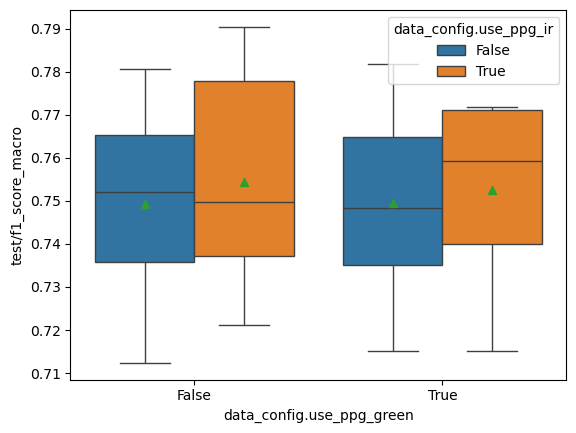

In [25]:
sns.boxplot(data=sweep_df_sel, x="data_config.use_ppg_green", y="test/f1_score_macro", hue="data_config.use_ppg_ir", showmeans=True)

In [74]:
sweep_id = "5ujkdrtw"

metrics = ["test/f1_score_macro", "fine_tune_test/f1_score_macro", "val/f1_score_macro", "test/precision_macro", "test/recall_macro", "test/accuracy_macro_macro"]

sweep_df = runs_df.loc[runs_df["sweep_id"] == sweep_id]
sweep_df = process_run(sweep_df, summary_keys=metrics, config_keys=["constrastive_adversarial", "data_config.use_ppg_green"])
sweep_df = add_confusion_matrix(sweep_df)


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\3997002902.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\3997002902.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\3997002902.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [373]:
import pyperclip

def generate_latex_table(grouped_df, metrics=None, caption="", percentage=False):
    if metrics is None:
        metrics = grouped_df.columns.levels[0]
    
    # Format mean ± std for each metric
    for metric in metrics:
        if percentage:
            grouped_df[(metric, 'mean ± std')] = grouped_df.apply(
                lambda row: f"{row[(metric, 'mean')]*100:.1f}\% ± {row[(metric, 'std')]*100:.1f}", axis=1
            )
        else:
            grouped_df[(metric, 'mean ± std')] = grouped_df.apply(
                lambda row: f"{row[(metric, 'mean')]:.3f} ± {row[(metric, 'std')]:.2f}", axis=1
            )
    
    # Drop the original mean and std columns (keeping only the formatted column)
    grouped_df = grouped_df.drop(columns=[(metric, 'mean') for metric in metrics] + [(metric, 'std') for metric in metrics])
    
    # Generate LaTeX table using pandas to_latex
    latex_table = grouped_df.to_latex(index=True, column_format="|c|" + "c|" * len(grouped_df.columns), 
                                      header=True, caption=caption)
    pyperclip.copy(latex_table)

    return latex_table

In [92]:

sweep_df.dropna(subset=["test/f1_score_macro"], inplace=True)
sweep_df = sweep_df[sweep_df["constrastive_adversarial"] == False]

In [96]:
agg_dict = {metric: ["mean", "std"] for metric in metrics}
agg_dict.update({"fine_tune_test/confusion_matrix": aggregate_confusion_matrices, "test/confusion_matrix": aggregate_confusion_matrices})

sweep_df_group = sweep_df.groupby("data_config.use_ppg_green").agg(agg_dict)
sweep_df_group = sweep_df_group[["test/f1_score_macro", "test/precision_macro","test/recall_macro","test/accuracy_macro_macro"]]
sweep_df_group = sweep_df_group.rename(index={True: "IMU + PPG", False: "IMU"}, columns={"test/f1_score_macro": "F1 Score", "test/precision_macro": "Precision", "test/recall_macro": "Recall", "test/accuracy_macro_macro": "Accuracy"})
generate_latex_table(sweep_df_group, caption="Results for different PPG channels")

'\\begin{table}\n\\caption{Results for different PPG channels}\n\\begin{tabular}{|c|c|c|c|c|}\n\\toprule\n & Accuracy & F1 Score & Precision & Recall \\\\\n & mean ± std & mean ± std & mean ± std & mean ± std \\\\\ndata_config.use_ppg_green &  &  &  &  \\\\\n\\midrule\nIMU & 0.77 ± 0.02 & 0.76 ± 0.02 & 0.76 ± 0.02 & 0.77 ± 0.02 \\\\\nIMU + PPG & 0.78 ± 0.02 & 0.78 ± 0.02 & 0.77 ± 0.02 & 0.78 ± 0.02 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [52]:
conf_matrices = sweep_df.groupby("data_config.use_ppg_green").agg({"test/confusion_matrix": aggregate_confusion_matrices})



def transform_conf_to_neg_vs_all(conf_matrix):
    conf_matrix = conf_matrix.copy()

    # Sum columns 1-8 into a single column (all positive predictions)
    pos_predictions = conf_matrix[:, 1:9].sum(axis=1, keepdims=True)
    conf_matrix = np.hstack((conf_matrix[:, [0]], pos_predictions))  # Keep column 0 (neg) and new pos column

    # Sum rows 1-8 into a single row (all positive actuals)
    pos_actuals = conf_matrix[1:9, :].sum(axis=0, keepdims=True)
    conf_matrix = np.vstack((conf_matrix[[0], :], pos_actuals))  # Keep row 0 (neg) and new pos row

    return conf_matrix

#conf_matrices = conf_matrices.applymap(transform_conf_to_neg_vs_all)


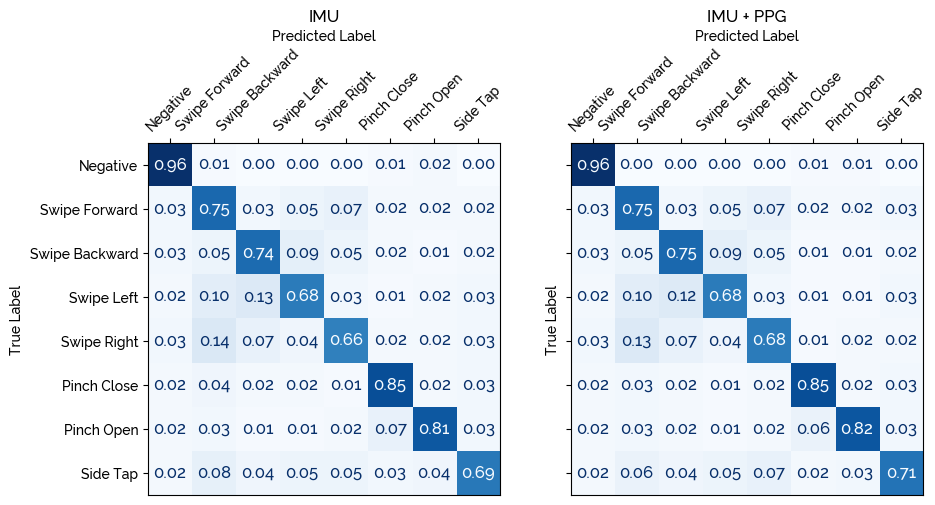

In [65]:


fig, axes = plot_agg_conufusion_matrix(conf_matrices, show_f1=False, normalize=True)
axes[0].set_title("IMU")
axes[1].set_title("IMU + PPG")
# change x tick labels and y tick

fig.savefig("confusion_matrix_best_imu_ppg.pdf", bbox_inches="tight")


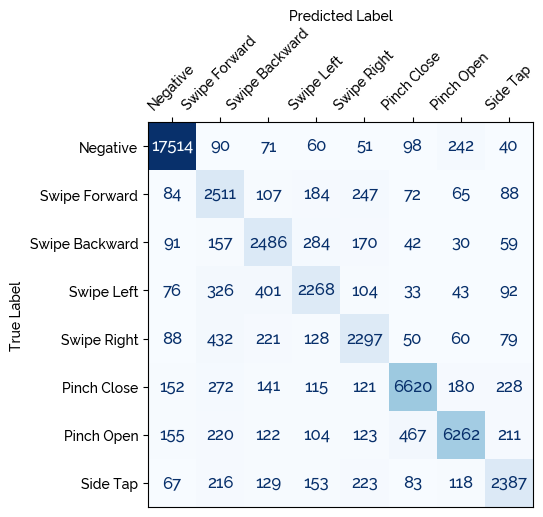

In [69]:

fig, axes = plt.subplots(1,1, figsize=(5, 5))
plot_confusion_matrix(conf_matrices.loc[True, "test/confusion_matrix"], axis=axes, show_f1=False, normalize=False)
# change x tick labels and y tick

fig.savefig("confusion_matrix_best_unnormalized.pdf", bbox_inches="tight")

In [ ]:

fig, axes = plt.subplots(1,1, figsize=(5, 5))
plot_confusion_matrix(conf_matrices.loc[True, "test/confusion_matrix"], axis=axes, show_f1=False, normalize=False)
# change x tick labels and y tick

fig.savefig("confusion_matrix_best_unnormalized.pdf", bbox_inches="tight")

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\2386821010.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  conf_neg_vs_all = conf_matrices.applymap(transform_conf_to_neg_vs_all)


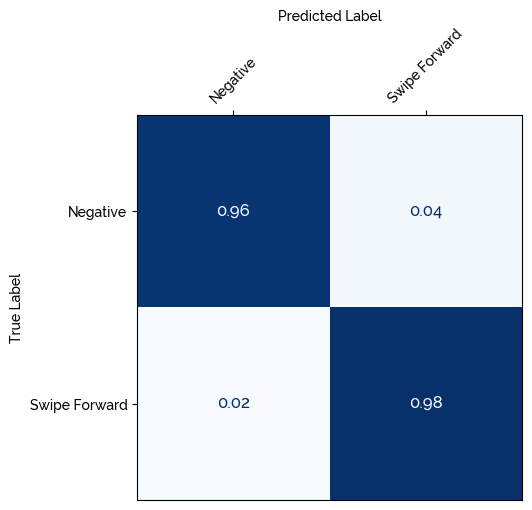

In [100]:
conf_neg_vs_all = conf_matrices.applymap(transform_conf_to_neg_vs_all)
plot_confusion_matrix(conf_neg_vs_all.loc[True, "test/confusion_matrix"], show_f1=False, normalize=True)

In [187]:
#rotate x-axis labels
# LOO splits

cmap = plt.get_cmap('tab10')


LOO_sweeps = ["n8yafy89"]
LOO_runs = runs_df[runs_df["sweep_id"].isin(LOO_sweeps)]
LOO_runs = LOO_runs[LOO_runs["state"] == "finished"]

LOO_runs = add_confusion_matrix(LOO_runs)
LOO_runs.loc[:,"participant"] = LOO_runs["config"].apply(lambda x: x["data_config.split_mode"].split("_")[1].lower())
LOO_runs = LOO_runs[~LOO_runs["participant"].isin(["heiyi", "matteo", "jack", "alex"])]
#LOO_runs.sort_values("participant", inplace=True)
participants = LOO_runs["participant"].unique()
LOO_runs = process_run(LOO_runs, summary_keys=["f1_score_macro", "accuracy", "precision", "recall", "f1_score"], config_keys=["data_config.use_ppg_green"])

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

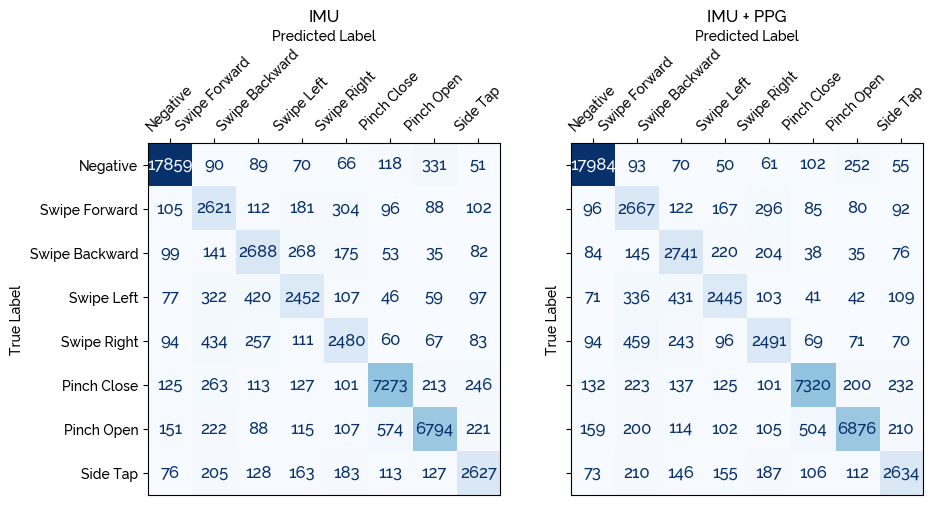

In [ ]:


LOO_runs_confusion = LOO_runs.groupby("data_config.use_ppg_green").agg({"val/confusion_matrix": aggregate_confusion_matrices})
fig, axes = plot_agg_conufusion_matrix(LOO_runs_confusion, show_f1=False, normalize=False)
axes[0].set_title("IMU")
axes[1].set_title("IMU + PPG")
fig.savefig("confusion_matrix_best_imu_ppg_unnormalized.pdf", bbox_inches="tight")

fig, axes = plot_agg_conufusion_matrix(LOO_runs_confusion, show_f1=False, normalize=True)
axes[0].set_title("IMU")
axes[1].set_title("IMU + PPG")
fig.savefig("confusion_matrix_best_imu_ppg.pdf", bbox_inches="tight")

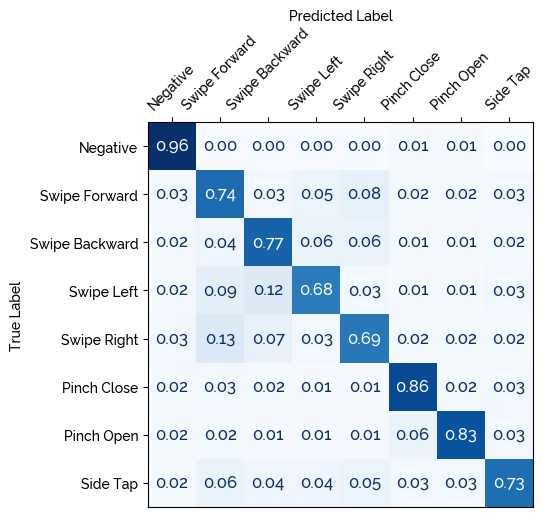

In [129]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_confusion_matrix(LOO_runs_confusion.loc[True, "val/confusion_matrix"], axis=axes, show_f1=False, normalize=True)
fig.savefig("confusion_matrix_best.pdf", bbox_inches="tight")


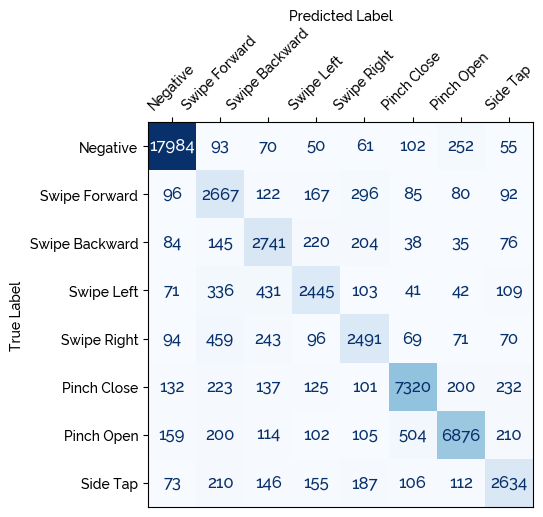

In [130]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_confusion_matrix(LOO_runs_confusion.loc[True, "val/confusion_matrix"], axis=axes, show_f1=False, normalize=False)
fig.savefig("confusion_matrix_best_unnormalized.pdf", bbox_inches="tight")

In [132]:
LOO_runs_confusion

,val/confusion_matrix
data_config.use_ppg_green,
False,"[[17859.0, 90.0, 89.0, 70.0, 66.0, 118.0, 331...."
True,"[[17984.0, 93.0, 70.0, 50.0, 61.0, 102.0, 252...."


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\1466047239.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  conf_neg_vs_all = LOO_runs_confusion.applymap(transform_conf_to_neg_vs_all)


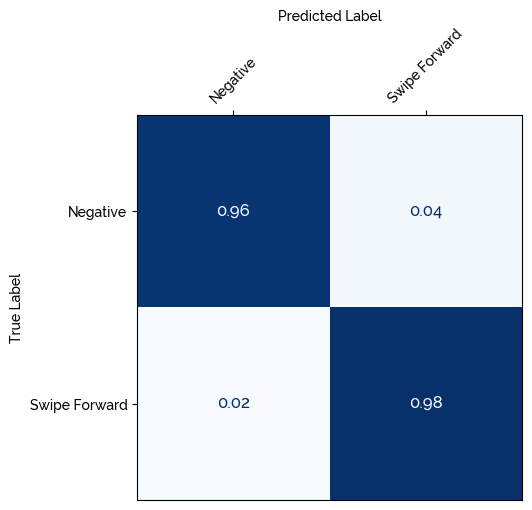

In [135]:
conf_neg_vs_all = LOO_runs_confusion.applymap(transform_conf_to_neg_vs_all)
plot_confusion_matrix(conf_neg_vs_all.loc[True, "val/confusion_matrix"], show_f1=False, normalize=True)
plt.savefig("confusion_matrix_negative_vs_all.pdf", bbox_inches="tight")

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\3604503264.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  conf_neg_vs_all = LOO_runs_confusion.applymap(transform_conf_to_neg_vs_all)


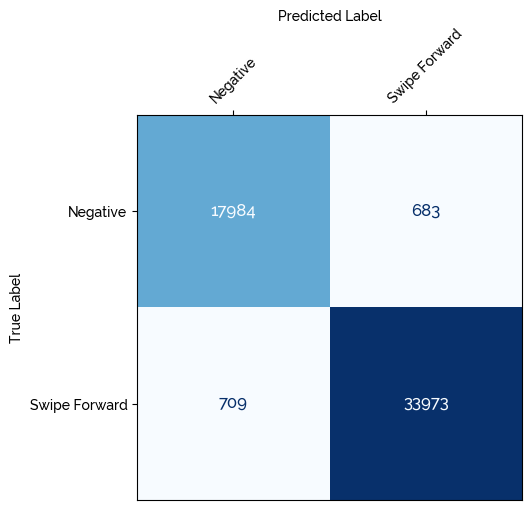

In [136]:
conf_neg_vs_all = LOO_runs_confusion.applymap(transform_conf_to_neg_vs_all)
plot_confusion_matrix(conf_neg_vs_all.loc[True, "val/confusion_matrix"], show_f1=False, normalize=False)
plt.savefig("confusion_matrix_negative_vs_all_unnormalized.pdf", bbox_inches="tight")

In [405]:
LOO_runs_table = LOO_runs.groupby("data_config.use_ppg_green").agg({"val/f1_score_macro": ["mean", "std"], "val/accuracy": ["mean", "std"], "val/precision_macro": ["mean", "std"], "val/recall_macro": ["mean", "std"]})
LOO_runs_table = LOO_runs_table.rename(index={True: "IMU + PPG", False: "IMU"})
LOO_runs_table = LOO_runs_table.rename(index={True: "IMU + PPG", False: "IMU"}, columns={"val/f1_score_macro": "F1 Score", "val/precision_macro": "Precision", "val/recall_macro": "Recall", "val/accuracy": "Accuracy"})


LOO_finetune = LOO_runs.groupby("data_config.use_ppg_green").agg({"fine_tune_val/f1_score_macro": ["mean", "std"], "fine_tune_val/accuracy": ["mean", "std"], "fine_tune_val/precision_macro": ["mean", "std"], "fine_tune_val/recall_macro": ["mean", "std"]})
LOO_finetune = LOO_finetune.rename(index={True: "IMU + PPG Finetune", False: "IMU Finetune"})
LOO_finetune = LOO_finetune.rename(index={True: "IMU + PPG", False: "IMU"}, columns={"fine_tune_val/f1_score_macro": "F1 Score", "fine_tune_val/precision_macro": "Precision", "fine_tune_val/recall_macro": "Recall", "fine_tune_val/accuracy": "Accuracy"})
LOO_runs_table = pd.concat([LOO_runs_table, LOO_finetune])
LOO_runs_table
generate_latex_table(LOO_runs_table, percentage=True)

'\\begin{tabular}{|c|c|c|c|c|}\n\\toprule\n & Accuracy & F1 Score & Precision & Recall \\\\\n & mean ± std & mean ± std & mean ± std & mean ± std \\\\\ndata_config.use_ppg_green &  &  &  &  \\\\\n\\midrule\nIMU & 83.2\\% ± 6.9 & 77.2\\% ± 7.7 & 78.0\\% ± 7.3 & 78.4\\% ± 7.6 \\\\\nIMU + PPG & 83.9\\% ± 6.4 & 78.0\\% ± 7.3 & 78.8\\% ± 6.8 & 79.0\\% ± 7.5 \\\\\nIMU Finetune & 84.7\\% ± 6.4 & 79.1\\% ± 7.5 & 79.4\\% ± 7.1 & 80.1\\% ± 7.6 \\\\\nIMU + PPG Finetune & 85.3\\% ± 6.2 & 79.7\\% ± 7.1 & 79.9\\% ± 6.8 & 80.8\\% ± 7.1 \\\\\n\\bottomrule\n\\end{tabular}\n'

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\138177550.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["summary"].apply(lambda x: x.get("val/accuracy", 0))
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\138177550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["summary"].apply(lambda x: x.get("val/accuracy", 0))


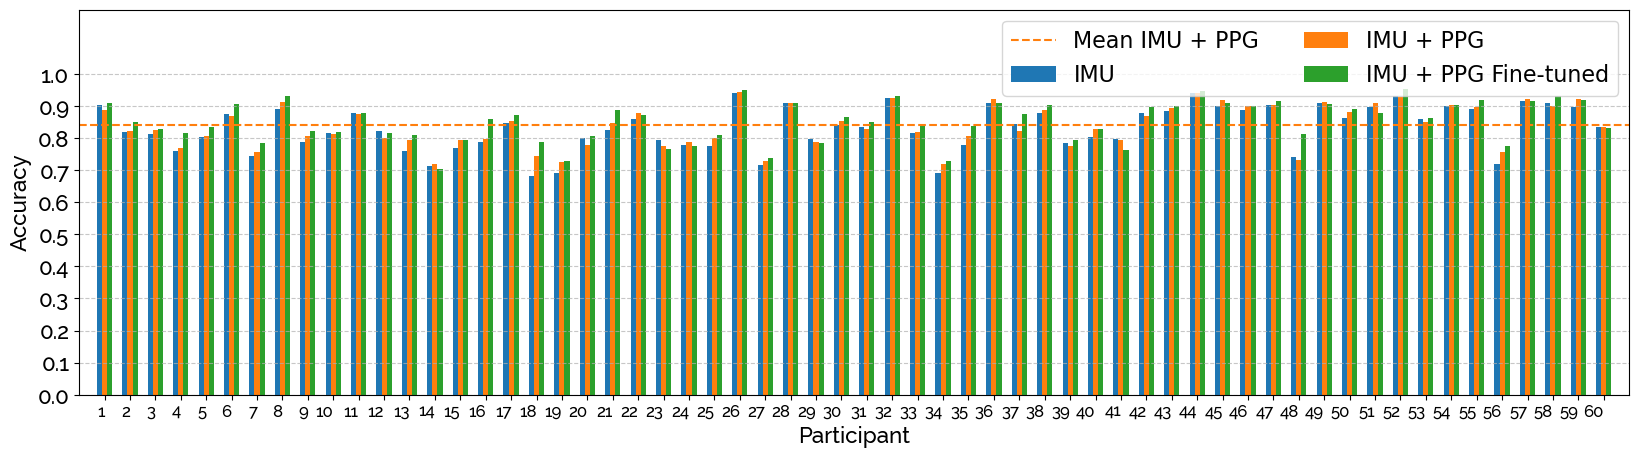

In [463]:

cmap = plt.get_cmap('tab10')
LOO_runs_all = LOO_runs[LOO_runs.apply(lambda x:x["config"]["data_config.use_ppg_green"], axis=1)]
LOO_runs_wo_ppg = LOO_runs[~LOO_runs.apply(lambda x:x["config"]["data_config.use_ppg_green"], axis=1)]
LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["summary"].apply(lambda x: x.get("val/accuracy", 0))
LOO_runs_wo_ppg = LOO_runs_wo_ppg[["participant", "accuracy_wo_ppg"]]
LOO_runs_all = pd.merge(LOO_runs_all, LOO_runs_wo_ppg, on="participant", how="left")

LOO_runs_all["accuracy"] = LOO_runs_all["val/accuracy"]
LOO_runs_all["fine_tune_accuracy"] = LOO_runs_all["fine_tune_val/accuracy"]
mean_accuracy = LOO_runs_all["accuracy"].mean()
LOO_runs_all = LOO_runs_all.iloc[:]

participants = LOO_runs_all["participant"].unique()

x = np.arange(len(participants), )  # X-axis positions for participants
width = 0.2  # Width of each bar
fig, ax = plt.subplots(1, figsize=(20, 5), sharex=True, sharey=True)
ax.bar(x - width, LOO_runs_all["accuracy_wo_ppg"], width=width, label="IMU", color=cmap(0))
ax.bar(x , LOO_runs_all["accuracy"], width=width, label="IMU + PPG", color=cmap(1))
ax.bar(x + width, LOO_runs_all["fine_tune_accuracy"], width=width, label="IMU + PPG Fine-tuned", color=cmap(2))

ax.set_xticks(x)
ax.set_xticklabels(np.arange(len(participants)) + 1, rotation=0, ha="right")
ax.set_xlim(-1, len(participants))

# make y-axis grid
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

#ax.set_title("Acuuarcy per Participant with LOO split")
ax.set_ylabel("Accuracy", font = FONT, fontsize=16)
ax.set_xlabel("Participant", font = FONT, fontsize=16)
ax.set_ylim(0, 1.2)

ax.axhline(mean_accuracy, color=cmap(1), linestyle="--", label="Mean IMU + PPG")

ax.legend(loc = "upper right", ncols=2,  fontsize=16)



#set font for ticks
for tick in ax.get_xticklabels() :
    tick.set_fontproperties(FONT)
    tick.set_fontsize(12)
for tick in  ax.get_yticklabels():
    tick.set_fontproperties(FONT)
    tick.set_fontsize(16)




#mean_f1_score = LOO_runs_all["f1_score"].mean()
#mean_f1_score_finetune = LOO_runs_all["f1_score_finetune"].mean()
#print(f"Mean F1 Score: {mean_f1_score}")
#print(f"Mean F1 Score Fine-tuned: {mean_f1_score_finetune}")

fig.savefig("LOO_accuracy_w_mean.pdf", bbox_inches='tight')

In [795]:
LOO_runs_all["accuracy"].describe()

count    60.000000
mean      0.839208
std       0.064198
min       0.718659
25%       0.793094
50%       0.832283
75%       0.898739
max       0.943396
Name: accuracy, dtype: float64

In [479]:
# Sort by accuracy
LOO_runs_all_sorted = LOO_runs_all.sort_values("accuracy")

# Number of groups
num_groups = 5
group_size = len(LOO_runs_all) // num_groups  # Ensure equal-sized bins

# Store results
results = []

for i in range(num_groups):
    start_idx = i * group_size
    end_idx = (i + 1) * group_size if i < num_groups - 1 else len(LOO_runs_all)
    
    group = LOO_runs_all_sorted.iloc[start_idx:end_idx]
    mean_values = group[["accuracy", "accuracy_wo_ppg"]].mean()
    
    accuracy_diff = mean_values["accuracy"] - mean_values["accuracy_wo_ppg"]
    
    results.append({
        "group": f"{i*20}-{(i+1)*20}%",
        "mean_accuracy": mean_values["accuracy"],
        "mean_accuracy_wo_ppg": mean_values["accuracy_wo_ppg"],
        "accuracy_difference": accuracy_diff
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

     group  mean_accuracy  mean_accuracy_wo_ppg  accuracy_difference
0    0-20%       0.748292              0.736117             0.012175
1   20-40%       0.798753              0.789177             0.009576
2   40-60%       0.837724              0.834475             0.003250
3   60-80%       0.889451              0.886236             0.003215
4  80-100%       0.921821              0.913150             0.008671


Text(0.5, 0, 'Participant')

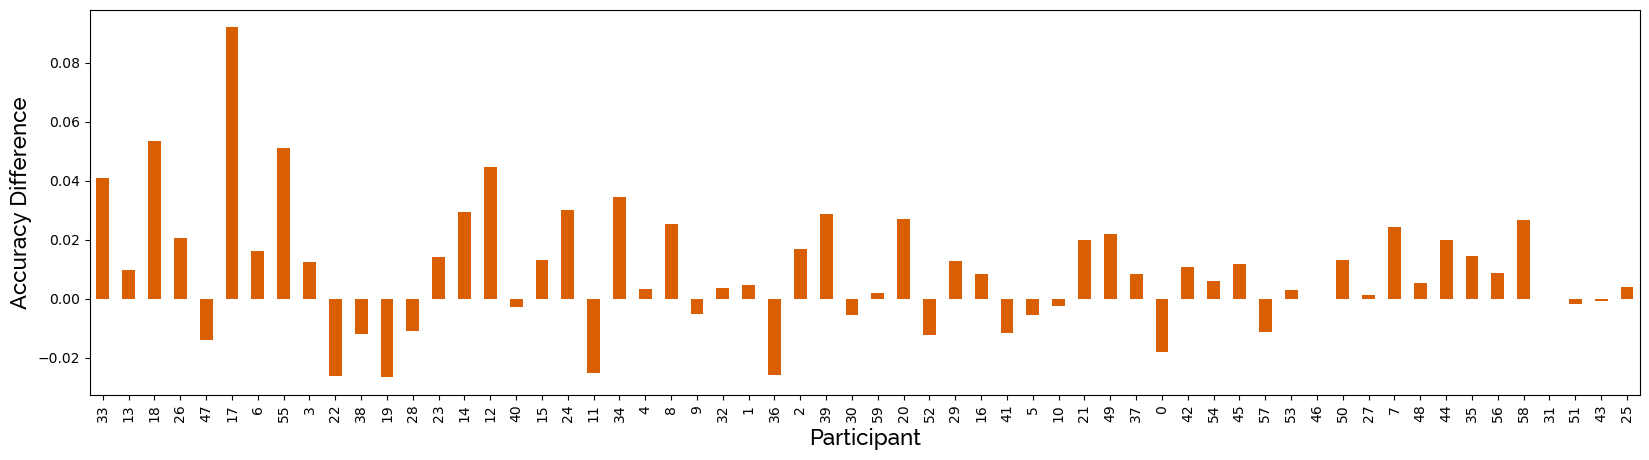

In [507]:
accuracy_diff = LOO_runs_all_sorted["accuracy"] - LOO_runs_all_sorted["accuracy_wo_ppg"]
accuracy_diff_relative = accuracy_diff / LOO_runs_all_sorted["accuracy_wo_ppg"]
accuracy_diff_relative.plot(kind="bar", figsize=(20, 5), color=cmap(1))
plt.ylabel("Accuracy Difference", font = FONT, fontsize=16)
plt.xlabel("Participant", font = FONT, fontsize=16)

In [478]:
from scipy.stats import ttest_rel

# Compute accuracy difference
LOO_runs_all_sorted["accuracy_diff"] = LOO_runs_all_sorted["accuracy"] - LOO_runs_all_sorted["accuracy_wo_ppg"]

# Number of groups
num_groups = 5
group_size = len(LOO_runs_all) // num_groups  # Ensure equal-sized bins

# Store results
p_values = []

for i in range(num_groups):
    start_idx = i * group_size
    end_idx = (i + 1) * group_size if i < num_groups - 1 else len(LOO_runs_all)
    
    group = LOO_runs_all_sorted.iloc[start_idx:end_idx]

    # Perform paired t-test
    t_stat, p_value = ttest_rel(group["accuracy"], group["accuracy_wo_ppg"])
    
    p_values.append({
        "group": f"{i*20}-{(i+1)*20}%",
        "p_value": p_value
    })

# Convert results to DataFrame
p_values_df = pd.DataFrame(p_values)
print(p_values_df)

     group   p_value
0    0-20%  0.127805
1   20-40%  0.068719
2   40-60%  0.421497
3   60-80%  0.313953
4  80-100%  0.006538


In [474]:
from scipy.stats import ttest_rel

# Compute the paired t-test for the whole dataset
t_stat, p_value = ttest_rel(LOO_runs_all["accuracy"], LOO_runs_all["accuracy_wo_ppg"])

print("Paired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The difference in accuracy is statistically significant.")
else:
    print("The difference in accuracy is NOT statistically significant.")


Paired t-test results:
t-statistic: 3.5760
p-value: 0.0007
The difference in accuracy is statistically significant.


In [800]:
LOO_runs_participant_embedding = runs_df[runs_df["sweep_id"] == "4g449std"]
LOO_runs_participant_embedding["timestamp"] = LOO_runs_participant_embedding.apply(lambda x: x["config"]["timestamp"], axis=1)
run_name = LOO_runs_participant_embedding["timestamp"].apply(lambda x: f"/local/home/lhauptmann/gestures/GestureDetection/experiments/{x}/config.yml")
for rn in run_name:
    print("- " + rn)


- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_173931/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_173933/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_180437/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_181808/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_184918/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_185029/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_190659/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_191735/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_194052/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_195114/config.yml
- /local/home/lhauptmann/gestures/GestureDetection/experiments/2025-02-05_201231

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\424770301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LOO_runs_participant_embedding["timestamp"] = LOO_runs_participant_embedding.apply(lambda x: x["config"]["timestamp"], axis=1)


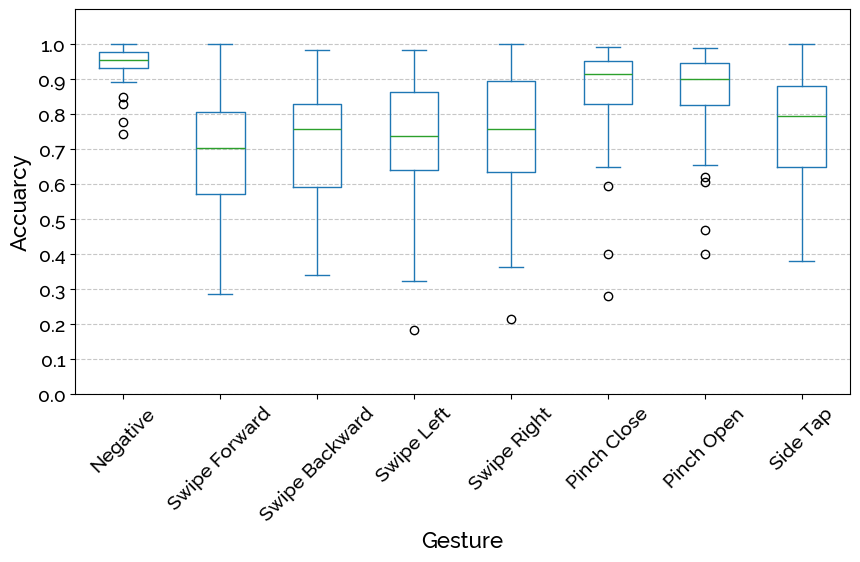

In [224]:
LOO_runs_gestures = LOO_runs.copy()
LOO_runs_gestures = LOO_runs_gestures[LOO_runs_gestures["data_config.use_ppg_green"] == True]
gesture_metrics = [el for el in LOO_runs_gestures.columns if el.startswith("val/accuracy_gesture")]
gesture_order = ["Negative", "Swipe Forward", "Swipe Backward", "Swipe Left", "Swipe Right", "Pinch Close", "Pinch Open", "Side Tap"]
gesture_metrics = sorted(gesture_metrics, key=lambda x: gesture_order.index(x.replace("val/accuracy_gesture_", "").replace("Nothing", "Negative")))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
LOO_runs_gestures = LOO_runs_gestures[gesture_metrics]

# pput columns in certain order
LOO_runs_gestures = LOO_runs_gestures[gesture_metrics]

LOO_runs_gestures.plot(kind="box", ax=ax)

ax.set_xticklabels([gesture.replace("val/accuracy_gesture_", "").replace("Nothing", "Negative") for gesture in gesture_metrics], rotation=45, fontdict={"fontproperties":FONT, "fontsize": 14})
#y ticks font
for tick in ax.get_yticklabels():
    tick.set_fontproperties(FONT)
    tick.set_fontsize(14)
ax.set_ylabel("Accuarcy", font = FONT, fontsize=16)
ax.set_xlabel("Gesture", font = FONT, fontsize=16)
ax.set_ylim(0, 1.1)

#add grid every 0.1
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.yaxis.grid(True, linestyle='--', alpha=0.7)


fig.savefig("LOO_gesture_accuarcy.pdf", bbox_inches='tight')

In [532]:
ft_sweep_ids = ["n8yafy89", "wah43eqm"] # fine tune
ft_sweeps = load_sweeps(ft_sweep_ids, runs_df)
f1_sweeps = process_run(ft_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["data_config.use_ppg_green", "constrastive_adversarial", "data_config.use_ppg_ir", "load_config", "fine_tune_gestures_per_participant"])
f1_sweeps = f1_sweeps[f1_sweeps["constrastive_adversarial"] != True]
f1_sweeps = f1_sweeps[f1_sweeps["state"] == "finished"]
f1_sweeps = f1_sweeps[f1_sweeps["data_config.use_ppg_ir"] == True]
f1_sweeps["participant"] = f1_sweeps["config"].apply(lambda x: x["data_config.split_mode"].split("_")[1].lower() if len(x["data_config.split_mode"].split("_")) > 1 else "all")
f1_sweeps = f1_sweeps[~f1_sweeps["participant"].isin(["heiyi", "matteo", "jack", "alex"])]


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

In [425]:
f1_sweeps["f1_score"] = f1_sweeps.apply(lambda x: x["val/f1_score_macro"] if pd.notna(x["val/f1_score_macro"]) else x["fine_tune_test/f1_score_macro"], axis=1)
f1_sweeps["accuracy"] = f1_sweeps.apply(lambda x: x["val/accuracy"] if pd.notna(x["val/accuracy"]) else x["fine_tune_test/accuracy"], axis=1)
f1_sweeps["recall"] = f1_sweeps.apply(lambda x: x["val/recall_macro"] if pd.notna(x["val/recall_macro"]) else x["fine_tune_test/recall_macro"], axis=1)
f1_sweeps["precision"] = f1_sweeps.apply(lambda x: x["val/precision_macro"] if pd.notna(x["val/precision_macro"]) else x["fine_tune_test/precision_macro"], axis=1)
f1_sweeps["fine_tune"] = ~f1_sweeps["load_config"].isna()
f1_sweeps.loc[~f1_sweeps["fine_tune"], "fine_tune_gestures_per_participant"] = 0
f1_sweeps["fine_tune_gestures_per_participant"] = f1_sweeps["fine_tune_gestures_per_participant"].astype(int) 

In [427]:
f1_sweeps_results = f1_sweeps.groupby("fine_tune_gestures_per_participant")[["accuracy", "f1_score", "recall", "precision"]].agg(["mean", "std"])
generate_latex_table(f1_sweeps_results, percentage=True)

'\\begin{tabular}{|c|c|c|c|c|}\n\\toprule\n & accuracy & f1_score & recall & precision \\\\\n & mean ± std & mean ± std & mean ± std & mean ± std \\\\\nfine_tune_gestures_per_participant &  &  &  &  \\\\\n\\midrule\n0 & 83.9\\% ± 6.4 & 78.0\\% ± 7.3 & 79.0\\% ± 7.5 & 78.8\\% ± 6.8 \\\\\n1 & 84.0\\% ± 6.5 & 78.3\\% ± 7.6 & 79.2\\% ± 7.7 & 79.0\\% ± 7.3 \\\\\n5 & 85.4\\% ± 6.4 & 79.9\\% ± 7.4 & 80.8\\% ± 7.4 & 80.3\\% ± 7.1 \\\\\n10 & 86.2\\% ± 6.2 & 80.8\\% ± 7.6 & 81.9\\% ± 7.5 & 80.9\\% ± 7.3 \\\\\n20 & 88.0\\% ± 5.5 & 82.6\\% ± 7.3 & 84.2\\% ± 6.9 & 82.3\\% ± 7.4 \\\\\n\\bottomrule\n\\end{tabular}\n'

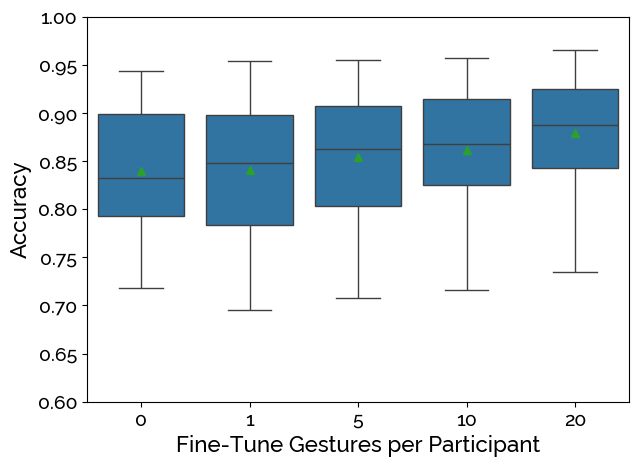

In [403]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxplot(data=f1_sweeps, x="fine_tune_gestures_per_participant", y="accuarcy", showmeans=True, ax=ax)

ax.set_ylabel("Accuracy", font = FONT, fontsize=16)
ax.set_xlabel("Fine-Tune Gestures per Participant", font = FONT, fontsize=16)
# set ticks font
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(FONT)
    tick.set_fontsize(14)

ax.set_ylim(0.6, 1)
fig.savefig("fine_tune_gestures_per_participant.pdf", bbox_inches='tight')


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

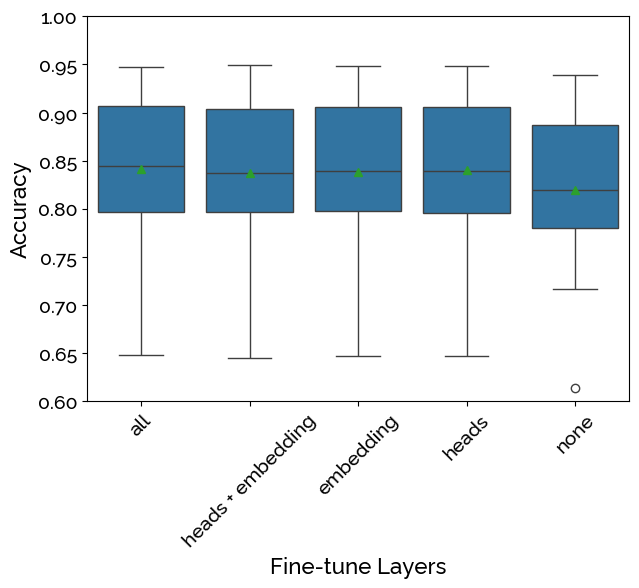

In [824]:
ft_sweep_ids = ["fyqt9qbp", "zns7jhel", "4g449std"] # fine tune
ft_sweeps = load_sweeps(ft_sweep_ids, runs_df)
f1_sweeps = process_run(ft_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["split_mode", "load_config", "fine_tune_freeze"])
f1_sweeps = f1_sweeps[f1_sweeps["state"] == "finished"]
#f1_sweeps["participant"] = f1_sweeps["config"].apply(lambda x: x["data_config.split_mode"].split("_")[1].lower() if len(x["data_config.split_mode"].split("_")) > 1 else "all")
#f1_sweeps = f1_sweeps[~f1_sweeps["participant"].isin(["heiyi", "matteo", "jack", "alex"])]

f1_sweeps["f1_score"] = f1_sweeps.apply(lambda x: x["val/f1_score_macro"] if pd.notna(x["val/f1_score_macro"]) else x["fine_tune_test/f1_score_macro"], axis=1)
f1_sweeps["accuracy"] = f1_sweeps.apply(lambda x: x["val/accuracy"] if pd.notna(x["val/accuracy"]) else x["fine_tune_test/accuracy"], axis=1)
f1_sweeps["recall"] = f1_sweeps.apply(lambda x: x["val/recall_macro"] if pd.notna(x["val/recall_macro"]) else x["fine_tune_test/recall_macro"], axis=1)
f1_sweeps["precision"] = f1_sweeps.apply(lambda x: x["val/precision_macro"] if pd.notna(x["val/precision_macro"]) else x["fine_tune_test/precision_macro"], axis=1)
f1_sweeps["fine_tune"] = ~f1_sweeps["load_config"].isna()
f1_sweeps.loc[~f1_sweeps["fine_tune"], "fine_tune_freeze"] = "test"

f1_sweeps["fine_tune_freeze"].replace({"test": "none", "none":"all","all_but_embedding": "embedding", "all_but_heads": "heads", "backbone": "heads + embedding"}, inplace=True)


fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxplot(data=f1_sweeps, x="fine_tune_freeze", y="accuracy", showmeans=True, ax=ax)

ax.set_ylabel("Accuracy", font = FONT, fontsize=16)
ax.set_xlabel("Fine-tune Layers", font = FONT, fontsize=16)
# set ticks font
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(FONT)
    tick.set_fontsize(14)

#rotate y ticks
plt.xticks(rotation=45)

ax.set_ylim(0.6, 1)
fig.savefig("fine_tune_freeze.pdf", bbox_inches='tight')


In [827]:
f1_sweeps.groupby("fine_tune_freeze")["accuracy"].describe()

,count,mean,std,min,25%,50%,75%,max
fine_tune_freeze,,,,,,,,
all,69.0,0.841905,0.077293,0.576802,0.796974,0.844037,0.907143,0.947047
embedding,69.0,0.838360,0.078851,0.564743,0.797914,0.839056,0.905786,0.948063
heads,69.0,0.839838,0.078439,0.564063,0.795970,0.839056,0.906122,0.948063
heads + embedding,69.0,0.836786,0.079130,0.563863,0.796296,0.837099,0.904031,0.949711
none,69.0,0.819862,0.082250,0.526393,0.780151,0.819118,0.887342,0.938986


In [446]:
mod_sweep_ids = ["dha55zl3", "k1v7rwdk", "qy8lxgx0"]
mod_sweeps = load_sweeps(mod_sweep_ids, runs_df)
mod_sweeps = process_run(mod_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["data_config.use_ppg_green", "constrastive_adversarial", "data_config.use_ppg_ir", "data_config.use_ppg_accel", "data_config.use_accel", "data_config.use_gyro"])
mod_sweeps.rename(columns={"data_config.use_ppg_green": "PPG", "data_config.use_ppg_ir": "PPG IR", "data_config.use_ppg_accel": "PPG Accel", "data_config.use_accel": "Accel", "data_config.use_gyro": "Gyro"}, inplace=True)
mod_sweeps = mod_sweeps[mod_sweeps["state"] == "finished"]

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [460]:
mod_sweeps["modalities"] = mod_sweeps.apply(lambda x: " + ".join([col for col in ["PPG", "PPG IR", "PPG Accel", "Accel", "Gyro"] if x[col]]), axis=1)
mod_sweeps.rename(columns={"val/f1_score_macro": "f1_score", "val/accuracy": "accuracy", "val/recall_macro": "recall", "val/precision_macro": "precision"}, inplace=True)
mod_sweeps_res = mod_sweeps.groupby("modalities").agg({"accuracy": ["mean", "std"], "f1_score": ["mean", "std"], "recall": ["mean", "std"], "precision": ["mean", "std"]})
mod_sweeps_res

accuracy            f1_score              recall  \
                                 mean       std      mean       std      mean   
modalities                                                                      
Accel                        0.807828  0.025135  0.727605  0.019483  0.733562   
Accel + Gyro                 0.829060  0.029639  0.761039  0.023654  0.767468   
Gyro                         0.731251  0.055276  0.637972  0.035742  0.647332   
PPG                          0.468513  0.063151  0.348653  0.022927  0.356425   
PPG + Accel + Gyro           0.835092  0.028133  0.768908  0.021537  0.775839   
PPG + PPG IR                 0.471326  0.053210  0.353216  0.020310  0.358844   
PPG + PPG IR + Accel + Gyro  0.837003  0.026444  0.769460  0.020904  0.777258   
PPG IR                       0.501529  0.061607  0.376003  0.023533  0.381355   
PPG IR + Accel + Gyro        0.833872  0.028053  0.766431  0.020138  0.773408   

                                      precision            
                                  std      mean       std  
modalities                                                 
Accel                        0.022242  0.725898  0.018326  
Accel + Gyro                 0.025140  0.758450  0.022570  
Gyro                         0.036593  0.635604  0.034667  
PPG                          0.026659  0.353476  0.019045  
PPG + Accel + Gyro           0.023320  0.765539  0.020658  
PPG + PPG IR                 0.021229  0.357727  0.020042  
PPG + PPG IR + Accel + Gyro  0.022475  0.765614  0.020377  
PPG IR                       0.023531  0.380829  0.023943  
PPG IR + Accel + Gyro        0.022048  0.763462  0.018834

In [461]:
generate_latex_table(mod_sweeps_res, percentage=True)

'\\begin{tabular}{|c|c|c|c|c|}\n\\toprule\n & accuracy & f1_score & recall & precision \\\\\n & mean ± std & mean ± std & mean ± std & mean ± std \\\\\nmodalities &  &  &  &  \\\\\n\\midrule\nAccel & 80.8\\% ± 2.5 & 72.8\\% ± 1.9 & 73.4\\% ± 2.2 & 72.6\\% ± 1.8 \\\\\nAccel + Gyro & 82.9\\% ± 3.0 & 76.1\\% ± 2.4 & 76.7\\% ± 2.5 & 75.8\\% ± 2.3 \\\\\nGyro & 73.1\\% ± 5.5 & 63.8\\% ± 3.6 & 64.7\\% ± 3.7 & 63.6\\% ± 3.5 \\\\\nPPG & 46.9\\% ± 6.3 & 34.9\\% ± 2.3 & 35.6\\% ± 2.7 & 35.3\\% ± 1.9 \\\\\nPPG + Accel + Gyro & 83.5\\% ± 2.8 & 76.9\\% ± 2.2 & 77.6\\% ± 2.3 & 76.6\\% ± 2.1 \\\\\nPPG + PPG IR & 47.1\\% ± 5.3 & 35.3\\% ± 2.0 & 35.9\\% ± 2.1 & 35.8\\% ± 2.0 \\\\\nPPG + PPG IR + Accel + Gyro & 83.7\\% ± 2.6 & 76.9\\% ± 2.1 & 77.7\\% ± 2.2 & 76.6\\% ± 2.0 \\\\\nPPG IR & 50.2\\% ± 6.2 & 37.6\\% ± 2.4 & 38.1\\% ± 2.4 & 38.1\\% ± 2.4 \\\\\nPPG IR + Accel + Gyro & 83.4\\% ± 2.8 & 76.6\\% ± 2.0 & 77.3\\% ± 2.2 & 76.3\\% ± 1.9 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [499]:
sweep_df_early_fusion

,summary,config,name,run_id,sweep_id,state,sweep_name,model_name


In [752]:
# Model architecture comparison

sweep_df_unet = load_sweeps(["84i8e0h1"], runs_df)
sweep_df_unet["model_name"] = "unet"

sweep_df_resnet = load_sweeps(["p7slwxzh"], runs_df)
sweep_df_resnet["model_name"] = "resnet"

sweep_df_transformer = load_sweeps(["gln612m8"], runs_df)
sweep_df_transformer["model_name"] = "transformer"

sweep_df_early_fusion = load_sweeps(["s7djova5"], runs_df)
sweep_df_early_fusion["model_name"] = "early_fusion"

sweep_df_vgg = load_sweeps(["dha55zl3"], runs_df)
sweep_df_vgg["model_name"] = "vgg"
sweep_df_vgg = sweep_df_vgg[sweep_df_vgg.apply(lambda x: x["config"]["data_config.use_ppg_green"] and x["config"]["data_config.use_ppg_ir"], axis=1)]


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [753]:
sweep_df_models = pd.concat([sweep_df_unet, sweep_df_resnet, sweep_df_early_fusion, sweep_df_vgg, sweep_df_transformer])
sweep_df_models = process_run(sweep_df_models, summary_keys=["f1_score", "accuracy", "recall", "precision"])

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

In [754]:
sweep_df_models.rename(columns={"test/f1_score_macro": "f1_score", "test/accuracy": "accuracy", "test/recall_macro": "recall", "test/precision_macro": "precision"}, inplace=True)
sweep_df_models_res = sweep_df_models.groupby("model_name").agg({"accuracy": ["mean", "std"], "f1_score": ["mean", "std"], "recall": ["mean", "std"], "precision": ["mean", "std"]})

generate_latex_table(sweep_df_models_res, percentage=True)


'\\begin{tabular}{|c|c|c|c|c|}\n\\toprule\n & accuracy & f1_score & recall & precision \\\\\n & mean ± std & mean ± std & mean ± std & mean ± std \\\\\nmodel_name &  &  &  &  \\\\\n\\midrule\nearly_fusion & 83.4\\% ± 2.9 & 76.6\\% ± 2.3 & 76.5\\% ± 2.6 & 77.4\\% ± 1.8 \\\\\nresnet & 82.1\\% ± 2.9 & 74.3\\% ± 2.0 & 74.4\\% ± 2.1 & 74.6\\% ± 2.1 \\\\\ntransformer & 62.0\\% ± 5.8 & 48.0\\% ± 2.0 & 47.9\\% ± 1.8 & 48.7\\% ± 2.2 \\\\\nunet & 80.3\\% ± 3.4 & 71.6\\% ± 2.6 & 71.8\\% ± 2.4 & 72.6\\% ± 2.0 \\\\\nvgg & 83.7\\% ± 2.6 & 77.0\\% ± 2.3 & 77.8\\% ± 2.5 & 76.6\\% ± 2.2 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [755]:
sweep_df_models.groupby("model_name").agg({"accuracy": ["mean", "std"], "f1_score": ["mean", "std"], "recall": ["mean", "std"], "precision": ["mean", "std"]})

accuracy            f1_score              recall            \
                  mean       std      mean       std      mean       std   
model_name                                                                 
early_fusion  0.833673  0.029005  0.766301  0.022650  0.764754  0.025886   
resnet        0.820664  0.029181  0.742618  0.020301  0.744063  0.020773   
transformer   0.620235  0.057901  0.479625  0.019648  0.478880  0.017650   
unet          0.803273  0.033847  0.715626  0.025788  0.718128  0.024465   
vgg           0.836863  0.026338  0.770096  0.023199  0.777624  0.024654   

             precision            
                  mean       std  
model_name                        
early_fusion  0.773935  0.018461  
resnet        0.746385  0.020971  
transformer   0.486967  0.021864  
unet          0.726495  0.020046  
vgg           0.765507  0.022399

In [ ]:
#rotate x-axis labels
# LOO splits

cmap = plt.get_cmap('tab10')


LOO_sweeps = ["n8yafy89"]
LOO_runs = runs_df[runs_df["sweep_id"].isin(LOO_sweeps)]
LOO_runs = LOO_runs[LOO_runs["state"] == "finished"]

LOO_runs = add_confusion_matrix(LOO_runs)
LOO_runs.loc[:,"participant"] = LOO_runs["config"].apply(lambda x: x["data_config.split_mode"].split("_")[1].lower())
LOO_runs = LOO_runs[~LOO_runs["participant"].isin(["heiyi", "matteo", "jack", "alex"])]
#LOO_runs.sort_values("participant", inplace=True)
participants = LOO_runs["participant"].unique()
LOO_runs = process_run(LOO_runs, summary_keys=["f1_score_macro", "accuracy", "precision", "recall", "f1_score"], config_keys=["data_config.use_ppg_green"])

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\549849578.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\549849578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]


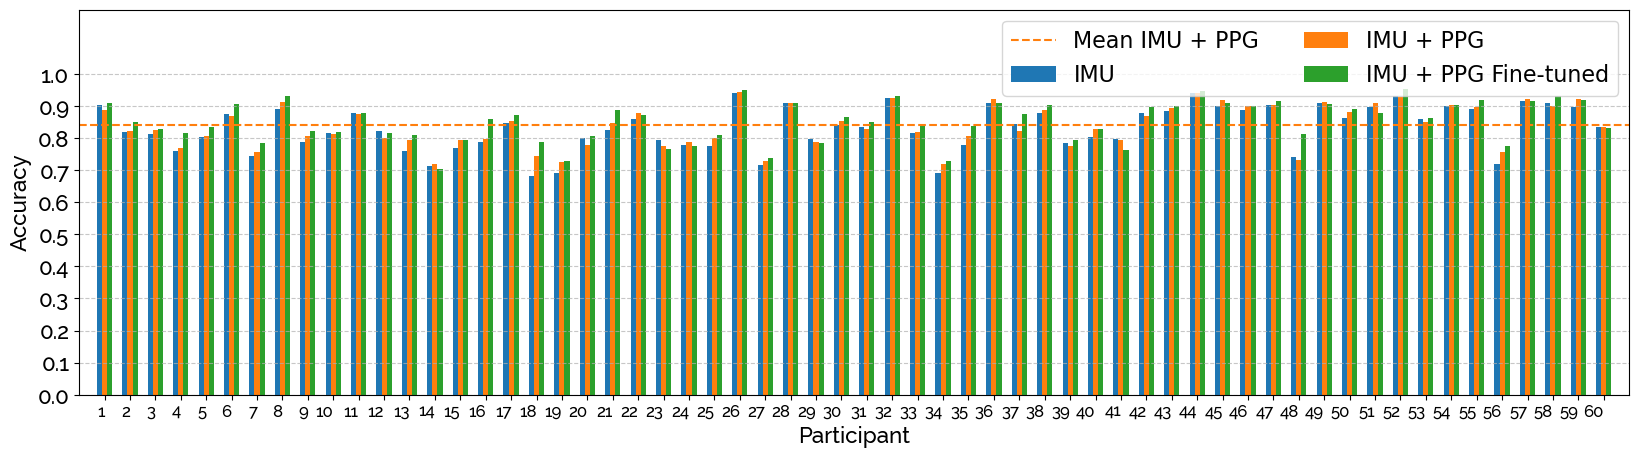

In [524]:

cmap = plt.get_cmap('tab10')
LOO_runs_all = LOO_runs[LOO_runs["data_config.use_ppg_green"]]
LOO_runs_wo_ppg = LOO_runs[LOO_runs["data_config.use_ppg_green"] == False]
LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
LOO_runs_wo_ppg = LOO_runs_wo_ppg[["participant", "accuracy_wo_ppg"]]
LOO_runs_all = pd.merge(LOO_runs_all, LOO_runs_wo_ppg, on="participant", how="left")

LOO_runs_all["accuracy"] = LOO_runs_all["val/accuracy"]
LOO_runs_all["fine_tune_accuracy"] = LOO_runs_all["fine_tune_val/accuracy"]
mean_accuracy = LOO_runs_all["accuracy"].mean()
LOO_runs_all = LOO_runs_all.iloc[:]

participants = LOO_runs_all["participant"].unique()

x = np.arange(len(participants), )  # X-axis positions for participants
width = 0.2  # Width of each bar
fig, ax = plt.subplots(1, figsize=(20, 5), sharex=True, sharey=True)
ax.bar(x - width, LOO_runs_all["accuracy_wo_ppg"], width=width, label="IMU", color=cmap(0))
ax.bar(x , LOO_runs_all["accuracy"], width=width, label="IMU + PPG", color=cmap(1))
ax.bar(x + width, LOO_runs_all["fine_tune_accuracy"], width=width, label="IMU + PPG Fine-tuned", color=cmap(2))

ax.set_xticks(x)
ax.set_xticklabels(np.arange(len(participants)) + 1, rotation=0, ha="right")
ax.set_xlim(-1, len(participants))

# make y-axis grid
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

#ax.set_title("Acuuarcy per Participant with LOO split")
ax.set_ylabel("Accuracy", font = FONT, fontsize=16)
ax.set_xlabel("Participant", font = FONT, fontsize=16)
ax.set_ylim(0, 1.2)

ax.axhline(mean_accuracy, color=cmap(1), linestyle="--", label="Mean IMU + PPG")

ax.legend(loc = "upper right", ncols=2,  fontsize=16)



#set font for ticks
for tick in ax.get_xticklabels() :
    tick.set_fontproperties(FONT)
    tick.set_fontsize(12)
for tick in  ax.get_yticklabels():
    tick.set_fontproperties(FONT)
    tick.set_fontsize(16)




#mean_f1_score = LOO_runs_all["f1_score"].mean()
#mean_f1_score_finetune = LOO_runs_all["f1_score_finetune"].mean()
#print(f"Mean F1 Score: {mean_f1_score}")
#print(f"Mean F1 Score Fine-tuned: {mean_f1_score_finetune}")

fig.savefig("LOO_accuracy_w_mean.pdf", bbox_inches='tight')

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\407384480.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\407384480.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]


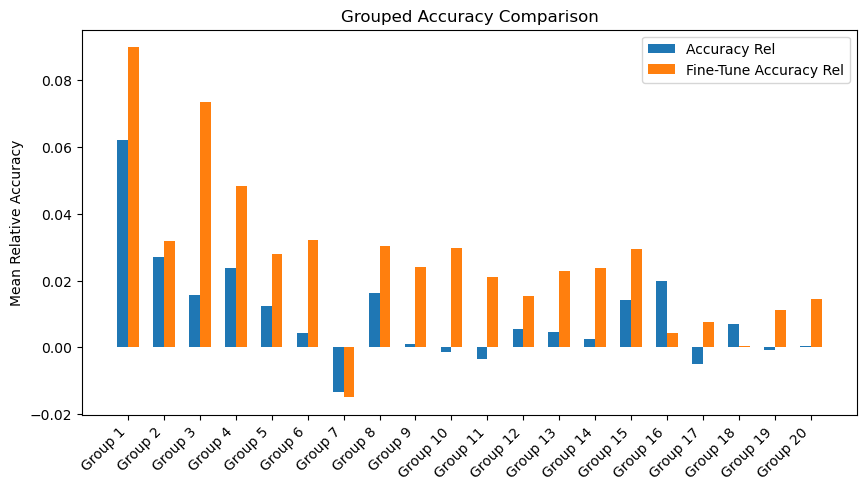

In [533]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cmap = plt.get_cmap('tab10')

# Filter Data
LOO_runs_all = LOO_runs[LOO_runs["data_config.use_ppg_green"]]

# Extract Accuracy Without PPG
LOO_runs_wo_ppg = LOO_runs[LOO_runs["data_config.use_ppg_green"] == False]
LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
LOO_runs_wo_ppg = LOO_runs_wo_ppg[["participant", "accuracy_wo_ppg"]]

# Merge Data
LOO_runs_all = pd.merge(LOO_runs_all, LOO_runs_wo_ppg, on="participant", how="left")

# Compute Relative Accuracy
LOO_runs_all["accuracy"] = LOO_runs_all["val/accuracy"]
LOO_runs_all["fine_tune_accuracy"] = LOO_runs_all["fine_tune_val/accuracy"]
LOO_runs_all["accuracy_rel"] = (LOO_runs_all["accuracy"] - LOO_runs_all["accuracy_wo_ppg"]) / LOO_runs_all["accuracy_wo_ppg"]
LOO_runs_all["fine_tune_accuracy_rel"] = (LOO_runs_all["fine_tune_accuracy"] - LOO_runs_all["accuracy_wo_ppg"]) / LOO_runs_all["accuracy_wo_ppg"]

# Sort by accuracy without PPG
LOO_runs_all.sort_values("accuracy_wo_ppg", inplace=True)

participants = LOO_runs_all["participant"].unique()

# Group participants into sets of 3
group_size = 3
groups = [participants[i:i + group_size] for i in range(0, len(participants), group_size)]

# Compute mean accuracy for each group
group_labels = [f"Group {i+1}" for i in range(len(groups))]
group_means_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy_rel"].mean()
    for group in groups
]
group_means_fine_tune_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "fine_tune_accuracy_rel"].mean()
    for group in groups
]

# Create Plot
fig, ax = plt.subplots(figsize=(10, 5))
x_positions = np.arange(len(groups))  # X positions for groups
width = 0.3  # Width of each bar

ax.bar(
    x_positions - width / 2, 
    group_means_accuracy_rel, 
    width=width, 
    color=cmap(0), 
    label="Accuracy Rel"
)
ax.bar(
    x_positions + width / 2, 
    group_means_fine_tune_accuracy_rel, 
    width=width, 
    color=cmap(1), 
    label="Fine-Tune Accuracy Rel"
)

# Formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(group_labels, rotation=45, ha="right")
ax.set_ylabel("Mean Relative Accuracy")
ax.set_title("Grouped Accuracy Comparison")
ax.legend()

plt.show()


In [542]:
ft_sweep_ids = ["wah43eqm"] # fine tune
ft_sweeps = load_sweeps(ft_sweep_ids, runs_df)
f1_sweeps = process_run(ft_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["data_config.use_ppg_green", "constrastive_adversarial", "data_config.use_ppg_ir", "load_config", "fine_tune_gestures_per_participant"])
f1_sweeps = f1_sweeps[f1_sweeps["constrastive_adversarial"] != True]
f1_sweeps = f1_sweeps[f1_sweeps["state"] == "finished"]
f1_sweeps = f1_sweeps[f1_sweeps["data_config.use_ppg_ir"] == True]
f1_sweeps["participant"] = f1_sweeps["config"].apply(lambda x: x["data_config.split_mode"].split("_")[1].lower() if len(x["data_config.split_mode"].split("_")) > 1 else "all")
f1_sweeps = f1_sweeps[~f1_sweeps["participant"].isin(["heiyi", "matteo", "jack", "alex"])]
f1_sweeps.rename(columns={"fine_tune_test/f1_score_macro": "f1_score", "fine_tune_test/accuracy": "accuracy", "fine_tune_test/recall_macro": "recall", "fine_tune_test/precision_macro": "precision"}, inplace=True)

f1_sweeps.groupby("fine_tune_gestures_per_participant").agg({"accuracy": ["mean", "std"], "f1_score": ["mean", "std"]})


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compati

accuracy            f1_score          
                                        mean       std      mean       std
fine_tune_gestures_per_participant                                        
1.0                                 0.840401  0.065335  0.782976  0.075537
5.0                                 0.854158  0.064019  0.799316  0.074362
10.0                                0.861511  0.061827  0.807770  0.075774
20.0                                0.879533  0.054957  0.826206  0.072794

In [635]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cmap = plt.get_cmap('tab10')

# Filter Data
LOO_runs_all = LOO_runs[LOO_runs["data_config.use_ppg_green"]]

# Extract Accuracy Without PPG
LOO_runs_wo_ppg = LOO_runs[LOO_runs["data_config.use_ppg_green"] == False]
LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
LOO_runs_wo_ppg = LOO_runs_wo_ppg[["participant", "accuracy_wo_ppg"]]

# Merge Data
LOO_runs_all = pd.merge(LOO_runs_all, LOO_runs_wo_ppg, on="participant", how="left")

# Compute Relative Accuracy
LOO_runs_all["accuracy"] = LOO_runs_all["val/accuracy"]
LOO_runs_all["fine_tune_accuracy"] = LOO_runs_all["fine_tune_val/accuracy"]
LOO_runs_all["accuracy_rel"] = (LOO_runs_all["accuracy"] - LOO_runs_all["accuracy_wo_ppg"]) / LOO_runs_all["accuracy_wo_ppg"] * 100
LOO_runs_all["fine_tune_accuracy_rel"] = (LOO_runs_all["fine_tune_accuracy"] - LOO_runs_all["accuracy_wo_ppg"]) / LOO_runs_all["accuracy_wo_ppg"] * 100

# Sort by accuracy without PPG
LOO_runs_all.sort_values("accuracy_wo_ppg", inplace=True)

participants = LOO_runs_all["participant"].unique()

# Group participants into sets of 3
group_size = 6
groups = [participants[i:i + group_size] for i in range(0, len(participants), group_size)]

# Compute mean accuracy for each group
group_labels = [f"{i+1}" for i in range(len(groups))]
group_means_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy_rel"].mean()
    for group in groups
]
group_means_fine_tune_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "fine_tune_accuracy_rel"].mean()
    for group in groups
]

# Load fine-tune sweeps
ft_sweep_ids = ["wah43eqm"]
ft_sweeps = load_sweeps(ft_sweep_ids, runs_df)

f1_sweeps = process_run(ft_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["data_config.use_ppg_green", "constrastive_adversarial", "data_config.use_ppg_ir", "load_config", "fine_tune_gestures_per_participant"])
f1_sweeps = f1_sweeps[(f1_sweeps["constrastive_adversarial"] != True) & (f1_sweeps["state"] == "finished") & (f1_sweeps["data_config.use_ppg_ir"] == True)]

# Extract participant names
#f1_sweeps["participant"] = f1_sweeps["config"].apply(lambda x: x["data_config.split_mode"].split("_")[1].lower() if len(x["data_config.split_mode"].split("_")) > 1 else "all")
#f1_sweeps = f1_sweeps[~f1_sweeps["participant"].isin(["heiyi", "matteo", "jack", "alex"])]

# Rename columns for clarity
f1_sweeps.rename(columns={"fine_tune_test/f1_score_macro": "f1_score", "fine_tune_test/accuracy": "accuracy", "fine_tune_test/recall_macro": "recall", "fine_tune_test/precision_macro": "precision"}, inplace=True)

f1_sweeps["timestamp"] = f1_sweeps["config"].apply(lambda x: x["load_config"].split("/")[-2])

# Extract timestamp from LOO_runs_all
LOO_runs_all["timestamp"] = LOO_runs_all["config"].apply(lambda x: x["timestamp"])

# Merge f1_sweeps with LOO_runs_all on the "timestamp" column
merged_data = pd.merge(f1_sweeps, LOO_runs_all[["timestamp", "participant", "accuracy_wo_ppg"]], on="timestamp", how="left")

# Now f1_sweeps contains the participant information based on matching timestamps
f1_sweeps = merged_data

print(f1_sweeps["participant"].unique())

# Compute mean accuracy per fine-tune gesture count
gesture_accuracy = f1_sweeps.groupby("fine_tune_gestures_per_participant")["accuracy"].mean()


# Prepare grouped data
fine_tune_gestures = gesture_accuracy.index.tolist()


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\900685129.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\900685129.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

['lars' 'dominik' 'tobias' 'ying' 'max' 'berken' 'bjoern' 'ida'
 'annamalai' 'zhipeng' 'yichi' 'martina' 'paul' 'jakob' 'felix' 'duan'
 'michel' 'liuxin' 'svenja' 'louisa' 'rayan' 'david' 'yang' 'antonia'
 'ben' 'sol' 'molly' 'matthias' 'xintong' 'kenna' 'athena' 'jamie'
 'jilian' 'ivan' 'mia' 'sel' 'jorge' 'ariane' 'daria' 'paula' 'hannah'
 'nicole' 'julia' 'sam' 'miro' 'amran' 'davud' 'anusha' 'caroline' 'frawa'
 'pam' 'miyuki' 'maedeh' 'eren' 'bo' 'moritz' 'rolando' 'oscar' 'lilian'
 'gonzalo']


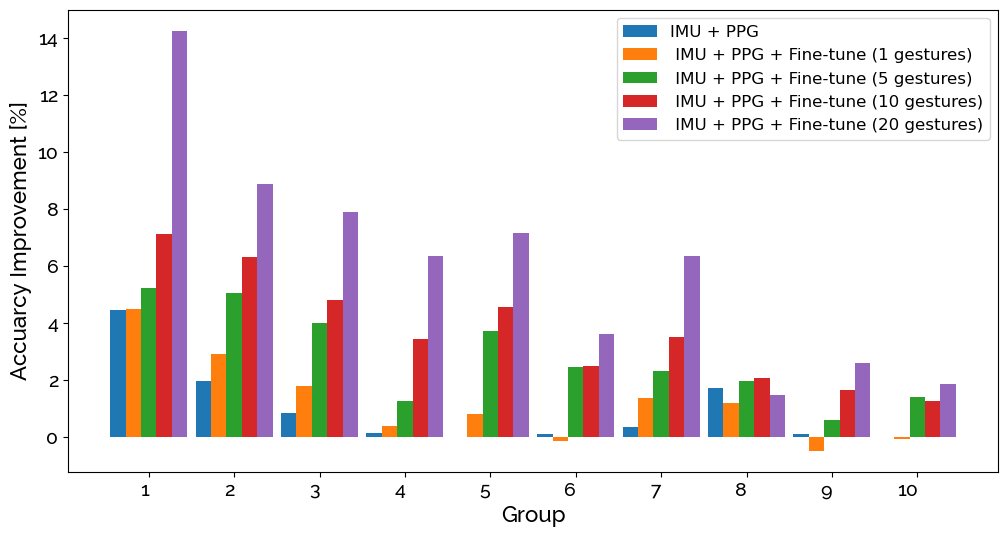

In [643]:
# Compute relative improvement for fine-tune gestures
f1_sweeps.dropna(subset=["accuracy"], inplace=True)

f1_sweeps["fine_tune_accuracy_rel"] = (f1_sweeps["accuracy"] - merged_data["accuracy_wo_ppg"]) / merged_data["accuracy_wo_ppg"] * 100

# Prepare grouped data for fine-tune gesture relative improvements
group_means_ft_gestures_rel = {g: [] for g in fine_tune_gestures}

for group in groups:
    for g in fine_tune_gestures:
        group_means_ft_gestures_rel[g].append(
            f1_sweeps.loc[f1_sweeps["participant"].isin(group) & (f1_sweeps["fine_tune_gestures_per_participant"] == g), "fine_tune_accuracy_rel"].mean()
        )

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
x_positions = np.arange(len(groups))  # X positions for groups
width = 0.18  # Width of each bar
num_bars = 1 + len(fine_tune_gestures)  # Total bars per group

# Plot relative accuracy bars
ax.bar(x_positions - width * (num_bars // 2), group_means_accuracy_rel, width, color=cmap(0), label="IMU + PPG")
#ax.bar(x_positions - width * (num_bars // 2) + width, group_means_fine_tune_accuracy_rel, width, color=cmap(1), label="Fine-Tune Accuracy Rel")

# Plot relative fine-tune gesture bars
for i, g in enumerate(fine_tune_gestures):
    ax.bar(
        x_positions - width * (num_bars // 2) + width * (1 + i), 
        group_means_ft_gestures_rel[g], 
        width, 
        color=cmap(1 + i), 
        label=f" IMU + PPG + Fine-tune ({int(g)} gestures)"
    )

# Formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(group_labels, rotation=0, ha="right")
ax.set_xlabel("Group", font = FONT, fontsize=16)
ax.set_ylabel("Accuarcy Improvement [%]", font = FONT, fontsize=16)
#ax.set_title("Grouped Relative Accuracy Comparison (Fine-Tune Gestures Included)")
ax.legend(loc="upper right", fontsize=12)

#set x tickes and y ticks font
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(FONT)
    tick.set_fontsize(14)

plt.show()


In [606]:
f1_sweeps.loc[f1_sweeps["participant"].isin(group) & (f1_sweeps["fine_tune_gestures_per_participant"] == g), "fine_tune_accuracy_rel"]

205   NaN
223   NaN
231   NaN
Name: fine_tune_accuracy_rel, dtype: float64

In [584]:

f1_sweeps["timestamp"] = f1_sweeps["config"].apply(lambda x: x["load_config"].split("/")[-2])

# Extract timestamp from LOO_runs_all
LOO_runs_all["timestamp"] = LOO_runs_all["config"].apply(lambda x: x["timestamp"])

# Merge f1_sweeps with LOO_runs_all on the "timestamp" column
merged_data = pd.merge(f1_sweeps, LOO_runs_all[["timestamp", "participant"]], on="timestamp", how="left")
merged_data["participant"]

0         lars
1      dominik
2       tobias
3         ying
4          max
        ...   
235         bo
236    rolando
237      oscar
238     lilian
239    gonzalo
Name: participant, Length: 240, dtype: object

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\3131589347.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\3131589347.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

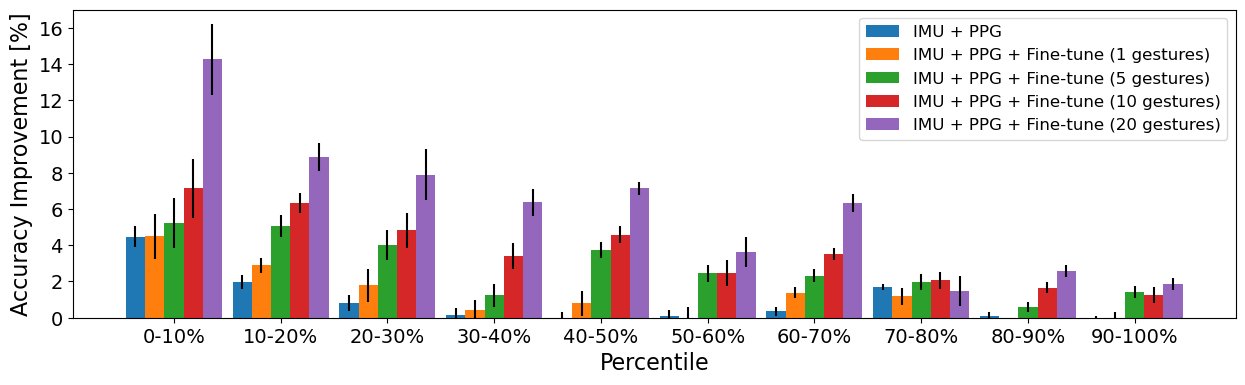

In [706]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cmap = plt.get_cmap('tab10')

# Filter Data
LOO_runs_all = LOO_runs[LOO_runs["data_config.use_ppg_green"]]

# Extract Accuracy Without PPG
LOO_runs_wo_ppg = LOO_runs[LOO_runs["data_config.use_ppg_green"] == False]
LOO_runs_wo_ppg["accuracy_wo_ppg"] = LOO_runs_wo_ppg["val/accuracy"]
LOO_runs_wo_ppg = LOO_runs_wo_ppg[["participant", "accuracy_wo_ppg"]]

# Merge Data
LOO_runs_all = pd.merge(LOO_runs_all, LOO_runs_wo_ppg, on="participant", how="left")

# Compute Relative Accuracy
LOO_runs_all["accuracy"] = LOO_runs_all["val/accuracy"]
LOO_runs_all["fine_tune_accuracy"] = LOO_runs_all["fine_tune_val/accuracy"]
LOO_runs_all["accuracy_rel"] = (LOO_runs_all["accuracy"] - LOO_runs_all["accuracy_wo_ppg"]) / LOO_runs_all["accuracy_wo_ppg"] * 100
LOO_runs_all["fine_tune_accuracy_rel"] = (LOO_runs_all["fine_tune_accuracy"] - LOO_runs_all["accuracy_wo_ppg"]) / LOO_runs_all["accuracy_wo_ppg"] * 100

# Sort by accuracy without PPG
LOO_runs_all.sort_values("accuracy_wo_ppg", inplace=True)

participants = LOO_runs_all["participant"].unique()

# Group participants into sets of 3
group_size = 6
groups = [participants[i:i + group_size] for i in range(0, len(participants), group_size)]

# Compute mean accuracy for each group
group_labels = [f"{i*10}-{(i+1) * 10}%" for i in range(len(groups))]
group_means_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy_rel"].mean()
    for group in groups
]
group_means_fine_tune_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "fine_tune_accuracy_rel"].mean()
    for group in groups
]

# Compute standard deviation for each group
group_std_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy_rel"].std() / 5
    for group in groups
]
group_std_fine_tune_accuracy_rel = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "fine_tune_accuracy_rel"].std() / 5
    for group in groups
]

# Load fine-tune sweeps
ft_sweep_ids = ["wah43eqm"]
ft_sweeps = load_sweeps(ft_sweep_ids, runs_df)

f1_sweeps = process_run(ft_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["data_config.use_ppg_green", "constrastive_adversarial", "data_config.use_ppg_ir", "load_config", "fine_tune_gestures_per_participant"])
f1_sweeps = f1_sweeps[(f1_sweeps["constrastive_adversarial"] != True) & (f1_sweeps["state"] == "finished") & (f1_sweeps["data_config.use_ppg_ir"] == True)]

# Rename columns for clarity
f1_sweeps.rename(columns={"fine_tune_test/f1_score_macro": "f1_score", "fine_tune_test/accuracy": "accuracy", "fine_tune_test/recall_macro": "recall", "fine_tune_test/precision_macro": "precision"}, inplace=True)

f1_sweeps["timestamp"] = f1_sweeps["config"].apply(lambda x: x["load_config"].split("/")[-2])

# Extract timestamp from LOO_runs_all
LOO_runs_all["timestamp"] = LOO_runs_all["config"].apply(lambda x: x["timestamp"])

# Merge f1_sweeps with LOO_runs_all on the "timestamp" column
merged_data = pd.merge(f1_sweeps, LOO_runs_all[["timestamp", "participant", "accuracy_wo_ppg"]], on="timestamp", how="left")

# Now f1_sweeps contains the participant information based on matching timestamps
f1_sweeps = merged_data

# Compute mean accuracy per fine-tune gesture count
gesture_accuracy = f1_sweeps.groupby("fine_tune_gestures_per_participant")["accuracy"].mean()

# Compute relative improvement for fine-tune gestures
f1_sweeps.dropna(subset=["accuracy"], inplace=True)
f1_sweeps["fine_tune_accuracy_rel"] = (f1_sweeps["accuracy"] - merged_data["accuracy_wo_ppg"]) / merged_data["accuracy_wo_ppg"] * 100

# Prepare grouped data for fine-tune gesture relative improvements
group_means_ft_gestures_rel = {g: [] for g in fine_tune_gestures}

for group in groups:
    for g in fine_tune_gestures:
        group_means_ft_gestures_rel[g].append(
            f1_sweeps.loc[f1_sweeps["participant"].isin(group) & (f1_sweeps["fine_tune_gestures_per_participant"] == g), "fine_tune_accuracy_rel"].mean()
        )

# Compute standard deviation for each group in fine-tune gestures
group_std_ft_gestures_rel = {g: [] for g in fine_tune_gestures}
for g in fine_tune_gestures:
    for group in groups:
        group_std_ft_gestures_rel[g].append(
            f1_sweeps.loc[f1_sweeps["participant"].isin(group) & (f1_sweeps["fine_tune_gestures_per_participant"] == g), "fine_tune_accuracy_rel"].std() / 5
        )

# Plotting
fig, ax = plt.subplots(figsize=(15, 4))
x_positions = np.arange(len(groups))  # X positions for groups
width = 0.18  # Width of each bar
num_bars = 1 + len(fine_tune_gestures)  # Total bars per group

# Plot relative accuracy bars
ax.bar(x_positions - width * (num_bars // 2), group_means_accuracy_rel, width, color=cmap(0), label="IMU + PPG", yerr=group_std_accuracy_rel)

# Plot relative fine-tune gesture bars
for i, g in enumerate(fine_tune_gestures):
    ax.bar(
        x_positions - width * (num_bars // 2) + width * (1 + i), 
        group_means_ft_gestures_rel[g], 
        width, 
        color=cmap(1 + i), 
        label=f"IMU + PPG + Fine-tune ({int(g)} gestures)",
        yerr=group_std_ft_gestures_rel[g]
    )

# Formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(group_labels, rotation=0, ha="center")
ax.set_xlabel("Percentile", fontsize=16)
ax.set_ylabel("Accuracy Improvement [%]", fontsize=16)
ax.set_ylim(0,17)
ax.legend(loc="upper right", fontsize=12)

# Set x tick and y tick font properties
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(14)

plt.savefig("accuarcy_per_group_relative.pdf", bbox_inches='tight')


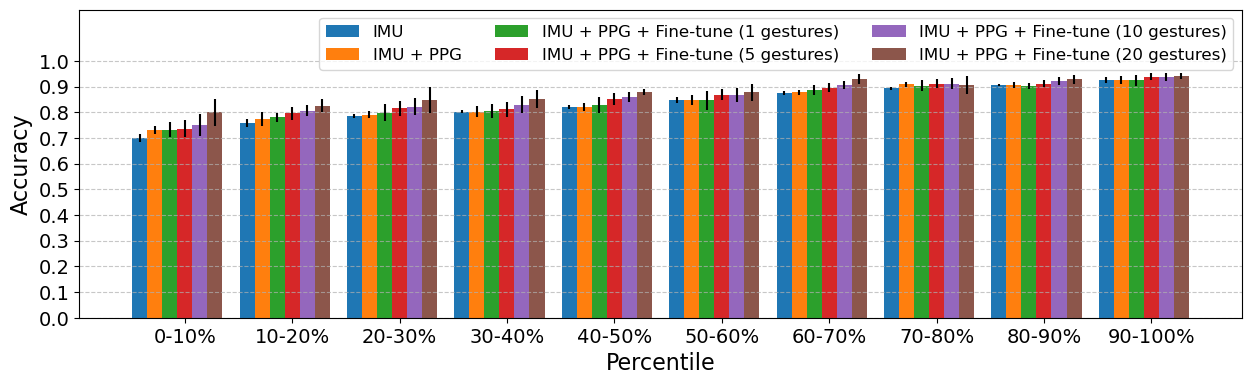

In [707]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your `LOO_runs_all` and `f1_sweeps` DataFrames are already defined

cmap = plt.get_cmap('tab10')

# Compute mean absolute accuracy for each group (just IMU)
group_means_accuracy_imu = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy"].mean()
    for group in groups
]

# Compute standard deviation for IMU accuracy
group_std_accuracy_imu = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy"].std()
    for group in groups
]

# Compute mean absolute accuracy for each group (without PPG)
group_means_accuracy_wo_ppg = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy_wo_ppg"].mean()
    for group in groups
]

# Compute standard deviation for accuracy without PPG
group_std_accuracy_wo_ppg = [
    LOO_runs_all.loc[LOO_runs_all["participant"].isin(group), "accuracy_wo_ppg"].std()
    for group in groups
]

# Compute mean absolute accuracy for fine-tune gestures (without PPG)
group_means_fine_tune_accuracy_wo_ppg = {
    g: [
        f1_sweeps.loc[f1_sweeps["participant"].isin(group) & (f1_sweeps["fine_tune_gestures_per_participant"] == g), "accuracy"].mean()
        for group in groups
    ]
    for g in fine_tune_gestures
}

# Compute standard deviation for fine-tune gestures accuracy
group_std_fine_tune_accuracy_wo_ppg = {
    g: [
        f1_sweeps.loc[f1_sweeps["participant"].isin(group) & (f1_sweeps["fine_tune_gestures_per_participant"] == g), "accuracy"].std()
        for group in groups
    ]
    for g in fine_tune_gestures
}

# Plotting
fig, ax = plt.subplots(figsize=(15, 4))
x_positions = np.arange(len(groups))  # X positions for groups
width = 0.14  # Width of each bar
num_bars = 2 + len(fine_tune_gestures)  # Total bars per group (just absolute)

# Plot absolute accuracy bars (IMU only) with std bars
ax.bar(
    x_positions - width * (num_bars // 2), 
    group_means_accuracy_wo_ppg, 
    width, 
    color=cmap(0), 
    label="IMU",
    yerr=group_std_accuracy_wo_ppg
)

# Plot absolute accuracy bars (IMU + PPG) with std bars
ax.bar(
    x_positions - width * (num_bars // 2) + width, 
    group_means_accuracy_imu, 
    width, 
    color=cmap(1), 
    label="IMU + PPG",
    yerr=group_std_accuracy_imu
)

# Plot absolute fine-tune gesture bars with std bars
for i, g in enumerate(fine_tune_gestures):
    ax.bar(
        x_positions - width * (num_bars // 2) + width * (2 + i), 
        group_means_fine_tune_accuracy_wo_ppg[g], 
        width, 
        color=cmap(2 + i), 
        label=f"IMU + PPG + Fine-tune ({int(g)} gestures)",
        yerr=group_std_fine_tune_accuracy_wo_ppg[g]
    )

# Formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(group_labels, rotation=0, ha="center")
ax.set_xlabel("Percentile", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)

# Legend
ax.legend(loc="upper right", fontsize=12, ncol=3)

# Set x tick and y tick font properties
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(14)

# add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
# add tick every 0.1
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1.2)


# Save the plot
plt.savefig("accuracy_per_group_absolute_with_imu_and_std.pdf", bbox_inches='tight')


In [740]:
# augmentations

aug_sweep_ids = ["xmiz5q5y"]
aug_sweeps = load_sweeps(aug_sweep_ids, runs_df)
aug_sweeps = process_run(aug_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["data_config.augmentations", "fold"])
aug_sweeps = aug_sweeps[aug_sweeps["state"] == "finished"]

aug_sweeps.rename(columns={"test/f1_score_macro": "f1_score", "test/accuracy": "accuracy", "test/recall_macro": "recall", "test/precision_macro": "precision"}, inplace=True)

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [737]:
aug_sweeps_res = aug_sweeps.groupby("data_config.augmentations").agg({"accuracy": ["mean", "std"], "f1_score": ["mean", "std"], "recall": ["mean", "std"], "precision": ["mean", "std"]})
generate_latex_table(aug_sweeps_res, percentage=True)

'\\begin{tabular}{|c|c|c|c|c|}\n\\toprule\n & accuracy & f1_score & recall & precision \\\\\n & mean ± std & mean ± std & mean ± std & mean ± std \\\\\ndata_config.augmentations &  &  &  &  \\\\\n\\midrule\n & 83.3\\% ± 3.0 & 76.2\\% ± 2.0 & 76.8\\% ± 2.3 & 76.0\\% ± 2.0 \\\\\njitter & 83.4\\% ± 2.4 & 76.3\\% ± 2.3 & 76.8\\% ± 2.3 & 76.1\\% ± 2.2 \\\\\nmixup & 83.2\\% ± 3.0 & 76.5\\% ± 2.0 & 77.0\\% ± 2.3 & 76.5\\% ± 1.8 \\\\\nnoise & 82.6\\% ± 2.7 & 75.6\\% ± 2.3 & 76.3\\% ± 2.5 & 75.3\\% ± 2.1 \\\\\nrotation & 84.2\\% ± 2.3 & 76.9\\% ± 2.3 & 77.5\\% ± 2.5 & 76.6\\% ± 2.1 \\\\\nscale & 83.7\\% ± 2.7 & 76.7\\% ± 2.2 & 77.2\\% ± 2.3 & 76.6\\% ± 2.1 \\\\\nwarp & 83.5\\% ± 2.3 & 76.2\\% ± 2.1 & 76.7\\% ± 2.3 & 76.1\\% ± 2.0 \\\\\nzoom & 82.5\\% ± 3.3 & 75.1\\% ± 2.9 & 75.8\\% ± 3.0 & 74.9\\% ± 2.7 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
aug_sweeps_res = aug_sweeps.groupby("data_config.augmentations").agg({"accuracy": ["mean", "std"], "f1_score": ["mean", "std"], "recall": ["mean", "std"], "precision": ["mean", "std"]})
aug_sweeps_res

In [744]:
aug_sweeps[]

accuracy            f1_score              recall  \
                               mean       std      mean       std      mean   
data_config.augmentations                                                     
                           0.832666  0.030111  0.762401  0.020280  0.767890   
jitter                     0.833913  0.024100  0.762841  0.022502  0.767560   
mixup                      0.831576  0.029873  0.765078  0.020379  0.769520   
noise                      0.825854  0.027084  0.756172  0.022679  0.763357   
rotation                   0.842209  0.022678  0.769056  0.022687  0.774760   
scale                      0.837122  0.026985  0.766997  0.021918  0.771776   
warp                       0.835018  0.023290  0.762151  0.021161  0.766898   
zoom                       0.824898  0.032522  0.750689  0.029081  0.757716   

                                    precision            
                                std      mean       std  
data_config.augmentations                                
                           0.022583  0.760474  0.019550  
jitter                     0.023135  0.761385  0.021835  
mixup                      0.023207  0.764707  0.017949  
noise                      0.025213  0.752775  0.021112  
rotation                   0.025269  0.766049  0.021312  
scale                      0.023051  0.765846  0.020565  
warp                       0.022682  0.760946  0.019541  
zoom                       0.030308  0.748841  0.027149

In [747]:
# Calculate improvements from the first row (baseline)
baseline = aug_sweeps_res.iloc[0]

# Subtract the baseline values from the other rows to get the improvements
improvements = aug_sweeps_res.iloc[1:].copy()

# Iterate over each metric and calculate the improvement
for metric in ['accuracy', 'f1_score', 'recall', 'precision']:
    improvements[(metric, 'mean')] -= baseline[(metric, 'mean')]

generate_latex_table(improvements, percentage=True)


'\\begin{tabular}{|c|c|c|c|c|}\n\\toprule\n & accuracy & f1_score & recall & precision \\\\\n & mean ± std & mean ± std & mean ± std & mean ± std \\\\\ndata_config.augmentations &  &  &  &  \\\\\n\\midrule\njitter & 0.1\\% ± 2.4 & 0.0\\% ± 2.3 & -0.0\\% ± 2.3 & 0.1\\% ± 2.2 \\\\\nmixup & -0.1\\% ± 3.0 & 0.3\\% ± 2.0 & 0.2\\% ± 2.3 & 0.4\\% ± 1.8 \\\\\nnoise & -0.7\\% ± 2.7 & -0.6\\% ± 2.3 & -0.5\\% ± 2.5 & -0.8\\% ± 2.1 \\\\\nrotation & 1.0\\% ± 2.3 & 0.7\\% ± 2.3 & 0.7\\% ± 2.5 & 0.6\\% ± 2.1 \\\\\nscale & 0.4\\% ± 2.7 & 0.5\\% ± 2.2 & 0.4\\% ± 2.3 & 0.5\\% ± 2.1 \\\\\nwarp & 0.2\\% ± 2.3 & -0.0\\% ± 2.1 & -0.1\\% ± 2.3 & 0.0\\% ± 2.0 \\\\\nzoom & -0.8\\% ± 3.3 & -1.2\\% ± 2.9 & -1.0\\% ± 3.0 & -1.2\\% ± 2.7 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [759]:
# n particiants

np_sweep_ids = ["r5ae4hv0"]
np_sweeps = load_sweeps(np_sweep_ids, runs_df)
np_sweeps = process_run(np_sweeps, summary_keys=["f1_score", "accuracy", "recall", "precision"], config_keys=["data_config.n_participants"])

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_sweep["sweep_name"] = sweep_name
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  run_df.at[i, key] = value
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_57980\671832614.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [762]:
np_sweeps.rename(columns={"test/f1_score_macro": "f1_score", "test/accuracy": "accuracy", "test/recall_macro": "recall", "test/precision_macro": "precision", "data_config.n_participants": "n_participants"}, inplace=True)
np_sweeps.groupby("n_participants").agg({"accuracy": ["mean", "std"], "f1_score": ["mean", "std"], "recall": ["mean", "std"], "precision": ["mean", "std"]})

accuracy            f1_score              recall            \
                    mean       std      mean       std      mean       std   
n_participants                                                               
-1.0            0.819715  0.056484  0.745650  0.051747  0.750316  0.052076   
 5.0            0.575015  0.068670  0.411031  0.079608  0.418029  0.081964   
 20.0           0.751589  0.049388  0.651513  0.035092  0.655093  0.035219   
 40.0           0.813908  0.046099  0.734325  0.036193  0.737971  0.035747   
 60.0           0.828013  0.053021  0.754845  0.047780  0.760578  0.047642   

               precision            
                    mean       std  
n_participants                      
-1.0            0.745819  0.047570  
 5.0            0.424150  0.081945  
 20.0           0.655195  0.032612  
 40.0           0.737700  0.027596  
 60.0           0.752900  0.046142

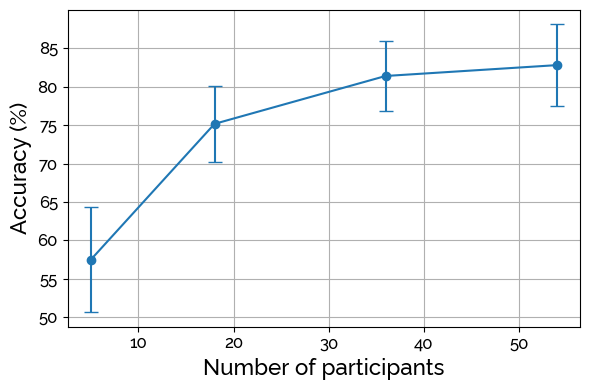

In [791]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming np_sweeps is your DataFrame with the data
# First, rename the columns
np_sweeps.rename(columns={
    "test/f1_score_macro": "f1_score", 
    "test/accuracy": "accuracy", 
    "test/recall_macro": "recall", 
    "test/precision_macro": "precision", 
    "data_config.n_participants": "n_participants"
}, inplace=True)

# Group by 'n_participants' and calculate mean and std for each metric
agg_data = np_sweeps.groupby("n_participants").agg({
    "accuracy": ["mean", "std"],
    "f1_score": ["mean", "std"],
    "recall": ["mean", "std"],
    "precision": ["mean", "std"]
})

# Remove the row with n_participants = -1
agg_data = agg_data[agg_data.index != -1]

# Extract the mean and std for accuracy
accuracy_mean = agg_data['accuracy']['mean'] * 100  # Convert to percentage
accuracy_std = agg_data['accuracy']['std'] * 100  # Convert to percentage
n_participants = accuracy_mean.index
n_participants = [5, 18, 36, 54]

# Create the plot
plt.figure(figsize=(6, 4))
plt.errorbar(n_participants, accuracy_mean, yerr=accuracy_std, fmt='o-', capsize=5, label='Accuracy')

# Set plot labels and title
plt.xlabel('Number of participants', fontsize=16, font=FONT)
plt.ylabel('Accuracy (%)', fontsize=16, font=FONT)
plt.grid(True)

# change x ticks and y ticks font
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():

    tick.set_fontproperties(FONT)
    tick.set_fontsize(12)


# Show the plot
plt.tight_layout()
#plt.show()
plt.savefig("accuracy_per_n_participants.pdf", bbox_inches='tight')


In [3]:
class A:
    def __init__(self, a =1, b=2):
        self.a = a
        self.b = b


a = A()

b = a.b
a.b = 3
a.b = b
print(a.b)

2


In [8]:
a = ""
print(bool(a))

False
